In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False
# Create GIF
def create_gif(image_list, gif_name, ds):
    frames = []
    for image_name in image_list:
        if image_name.endswith('.png'):
            print(image_name)
            frames.append(imageio.imread(image_name))
    # Save them as frames into a gif
    imageio.mimsave(gif_name, frames, 'GIF', duration = ds)
    return

In [ ]:
# This code aims do early post-process for P2 to save RAM, so that can run more simulation simoutanously 
# The cycling protocol will be the same as the first paper, until the solver problem is solved and can run GITT. 
# Mark: need to change all 'SEI' back to 'negative electrode SEI'
# Note that for Interstitial-diffusion limited SEI, two critical parameters are:
#     Inner SEI lithium interstitial diffusivity [m2.s-1] (15.0) and
#     Lithium interstitial reference concentration [mol.m-3] (1e-20), and they are on the numerator
#     have nothing to do with EC concentration 

In [2]:
# Define a function to calculate concentration change!
def Cal_new_con_for_Li_EC(Sol,Para,c_EC_0,c_e_0):
    #############################################################################################################################  
    ###############################           Step-1 Prepare parameters:        #################################################
    #############################################################################################################################  
    L_p   =Para["Positive electrode thickness [m]"]
    L_n   =Para["Negative electrode thickness [m]"]
    L_s   =Para["Separator thickness [m]"]
    L_y   =Para["Electrode width [m]"]   # Also update to change A_cc and therefore Q
    L_z   =Para["Electrode height [m]"]
    # Initial EC concentration  
    Ini_Ce_EC        =Para["Bulk solvent concentration [mol.m-3]"]  # Be careful when multiplying with pore volume to get amount in mole. Because of electrolyte dry out, that will give more amount than real.   
    # LLI due to electrode,Ratio of EC and lithium is 1:1 -> EC amount consumed is LLINegSEI[-1]
    LLINegSEI = Sol["Loss of lithium to negative electrode SEI [mol]"].entries[-1] - Sol["Loss of lithium to negative electrode SEI [mol]"].entries[0]
    LLINegLip = Sol["Loss of lithium to negative electrode lithium plating [mol]"].entries[-1] - Sol["Loss of lithium to negative electrode lithium plating [mol]"].entries[0]
    # Pore volume change with time:
    PoreVolNeg = Sol["X-averaged negative electrode porosity"].entries*L_n*L_y*L_z;
    PoreVolSep = Sol["X-averaged separator porosity"].entries*L_s*L_y*L_z;
    PoreVolPos = Sol["X-averaged positive electrode porosity"].entries*L_p*L_y*L_z;
    #############################################################################################################################  
    #####################       Step-2 Determine How much electrolyte is added, whether dry out:        #########################
    #############################################################################################################################  
    Vol_Elely_Tot_old = Para["Current total electrolyte volume in whole cell [m3]"] 
    Vol_Elely_JR_old  = Para["Current total electrolyte volume in jelly roll [m3]"] 
    Vol_Pore_tot_old  = PoreVolNeg[0] + PoreVolSep[0] + PoreVolPos[0]       # pore volume at start time of the run
    Vol_Pore_tot_new  = PoreVolNeg[-1] + PoreVolSep[-1] + PoreVolPos[-1]    # pore volume at end   time of the run, intrinsic variable 
    Vol_Pore_decrease = Vol_Pore_tot_old  - Vol_Pore_tot_new;
    # EC:lithium:SEI=2:2:1     for SEI=(CH2OCO2Li)2
    # Because inner and outer SEI partial molar volume is the same, just set one for whole SEI
    VmolSEI   = Para["Outer SEI partial molar volume [m3.mol-1]"] # 9.8e-5,
    VmolEC    = 9.667e-5  # Unit:m3.mol-1; According to Wiki, correct value: EC molar volume is :66.67 cm3.mol-1  = 6.667e-5, 
    Vol_EC_consumed  =  ( LLINegSEI + LLINegLip  ) * VmolEC    # Mark: Ruihe add LLINegLip, either with 2 or not, will decide how fast electrolyte being consumed!
    Vol_Elely_need   = Vol_EC_consumed - Vol_Pore_decrease
    Vol_SEI_increase = 0.5*LLINegSEI*VmolSEI   #  volume increase due to SEI
    Test_V = Vol_SEI_increase - Vol_Pore_decrease  #  This value should always be zero, but now not, which becomes the source of error!
    # Important: Calculate added electrolyte based on excessive electrolyte, can be: 1) added as required; 2) added some, but less than required; 3) added 0 
    if Vol_Elely_Tot_old > Vol_Elely_JR_old:                             # This means Vol_Elely_JR_old = Vol_Pore_tot_old ()
        if Vol_Elely_Tot_old-Vol_Elely_JR_old >= Vol_Elely_need:         # 1) added as required
            Vol_Elely_add     = Vol_Elely_need;
            Vol_Elely_Tot_new = Vol_Elely_Tot_old -  Vol_EC_consumed;
            Vol_Elely_JR_new  = Vol_Elely_JR_old  -  Vol_Pore_decrease;  # also equals to 'Vol_Pore_tot_new', or Vol_Pore_tot_old - Vol_Pore_decrease
            Ratio_Dryout = 1.0;
        else:                                                            # 2) added some, but less than required;                                                         
            Vol_Elely_add     = Vol_Elely_Tot_old - Vol_Elely_JR_old;   
            Vol_Elely_Tot_new = Vol_Elely_Tot_old - Vol_EC_consumed;
            Vol_Elely_JR_new  = Vol_Elely_Tot_new;                       # This means Vol_Elely_JR_new <= Vol_Pore_tot_new
            Ratio_Dryout = Vol_Elely_JR_new/Vol_Pore_tot_new;
    else:                                                                # 3) added 0 
        Vol_Elely_add = 0;
        Vol_Elely_Tot_new = Vol_Elely_Tot_old - Vol_EC_consumed;
        Vol_Elely_JR_new  = Vol_Elely_Tot_new; 
        Ratio_Dryout = Vol_Elely_JR_new/Vol_Pore_tot_new;
    #############################################################################################################################  
    ###################       Step-3 Electrolyte mixing, define ratio change for Li and EC concentration        #################
    #############################################################################################################################     
    # Next: start mix electrolyte based on previous defined equation
    # Lithium amount in liquid phase, at initial time point
    TotLi_Elely_JR_Old = Sol["Total lithium in electrolyte [mol]"].entries[-1];
    # Added lithium and EC amount in the added lithium electrolyte: - should always be really 'initial'
    AddLiMol   =  Vol_Elely_add*c_e_0
    AddECMol   =  Vol_Elely_add*c_EC_0
    # Total amount of Li and EC in current electrolyte:
    # Remember Li has two parts, initial and added; EC has three parts, initial, consumed and added
    TotLi_Elely_JR_New   = TotLi_Elely_JR_Old + AddLiMol
    TotECMol_JR   = Vol_Elely_JR_old*Ini_Ce_EC - LLINegSEI*2 + AddECMol
    Ratio_CeEC  = TotECMol_JR    /   Vol_Elely_JR_new   / Ini_Ce_EC
    Ratio_CeLi  = TotLi_Elely_JR_New    /   TotLi_Elely_JR_Old   /  Ratio_Dryout # Mark, change on 21-11-19
    Width_new   = Ratio_Dryout * L_y;
    # Collect the above parameter in Data_Pack to shorten the code  
    Data_Pack   = [Vol_EC_consumed, Vol_Elely_need, Test_V, Vol_Elely_add, Vol_Elely_Tot_new, Vol_Elely_JR_new, Vol_Pore_tot_new, Vol_Pore_decrease, Ratio_Dryout, Ratio_CeEC, Ratio_CeLi,Width_new, ]  # 11 in total
    return Data_Pack

print(Test_V)
print(Vol_Pore_tot_new)
print(Vol_Elely_JR_new)
print(Ratio_Dryout)
print(Vol_EC_consumed-Vol_Pore_decrease)


In [4]:
ChemistryChen=pb.parameter_sets.Chen2020_coupled   # 
Para_0=pb.ParameterValues(chemistry=ChemistryChen)
print(Para_0["Lithium metal partial molar volume [m3.mol-1]"]) # 
print(Para_0["Inner SEI lithium interstitial diffusivity [m2.s-1]"])
print(Para_0["Lithium interstitial reference concentration [mol.m-3]"])

1.3e-05
1e-20
15.0


In [4]:
# Define a function to update parameter and lithium concentration in solution     
def Update_param ( Para, Ratio_CeEC, Ratio_Dryout, Vol_Elely_Tot, Vol_Elely_JR ):
    Old_CeEC = Para["Bulk solvent concentration [mol.m-3]"]
    Old_L_y  = Para["Electrode width [m]"]
    Para.update(   {'Bulk solvent concentration [mol.m-3]':  Old_CeEC * Ratio_CeEC  })
    Para.update(   {'Current total electrolyte volume in whole cell [m3]':  Vol_Elely_Tot  })
    Para.update(   {'Current total electrolyte volume in jelly roll [m3]':  Vol_Elely_JR  })
    Para.update(   {'Ratio of electrolyte dry out in jelly roll':Ratio_Dryout})
    Para.update(   {'Electrode width [m]':Ratio_Dryout * Old_L_y})
    # Elely_Con_Dimless_old = Sol["Electrolyte concentration"].entries 
    # Sol.update(      {'Electrolyte concentration': Elely_Con_Dimless_old*Ratio_CeLi  })  # Important: update solution - turn out not work
    return Para   # call function: Para_new, Sol_new = Update_param ( Sol, Para, Ratio_CeLi, Ratio_CeEC, Ratio_Dryout )
# Para_update, Sol_update  = Update_param (  Sol_All_0[-1], Para_All[-1], Ratio_CeLi_All[-1], Ratio_CeEC_All[-1], Ratio_Dryout_All[-1]  )

# Define a function to calculate based on previous solution
def Run_Model_Base_On_Last_Solution( Model  , Sol, Ratio_CeLi, Para_update, ModelExperiment, Update_Cycles ):
    # Use Sulzer's method: inplace = false
    ModelTimer = pb.Timer()
    # Important line: define new model based on previous solution
    dict_short = {}; 
    list_short = [  "Discharge capacity [A.h]",   # mark Ruihe Li change for FullyCoupled as this is an old version of PyBaMM
        "Negative particle concentration",
        "Positive particle concentration",
        "Negative electrode potential",
        "Positive electrode potential",
        "Total negative electrode interfacial current density variable" ,
        "Total positive electrode interfacial current density variable",
        "Negative electrode porosity",
        "Separator porosity",
        "Positive electrode porosity",
        "Inner negative electrode SEI thickness",
        "Outer negative electrode SEI thickness",
        "Negative electrolyte potential",
        "Separator electrolyte potential",
        "Positive electrolyte potential",
        "Negative electrolyte concentration",
        "Separator electrolyte concentration",
        "Positive electrolyte concentration",   
        "Negative electrode lithium plating concentration",
        "Negative electrode dead lithium concentration",]
    for list_short_i in list_short:
        dict_short.update( { list_short_i : Sol.last_state[list_short_i].data  }  )
    dict_short["Negative electrolyte concentration"] = dict_short["Negative electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    dict_short["Separator electrolyte concentration"] = dict_short["Separator electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    dict_short["Positive electrolyte concentration"] = dict_short["Positive electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    ModelModel_new = Model.set_initial_conditions_from(dict_short, inplace=False)
    #Para_update.update(   {'Ambient temperature [K]':313.15 });   # run model at 45 degree C
    #Para_update.update(   {'Initial temperature [K]':313.15 });
    ModelSimnew = pb.Simulation(
        ModelModel_new,
        experiment = ModelExperiment, 
        parameter_values=Para_update, 
        solver = pb.CasadiSolver(),
    )
    Sol_new = ModelSimnew.solve(save_at_cycles = Update_Cycles) # save every several cycles, can save RAM greatly
    # print("Solved this model in {}".format(ModelTimer.time()))
    return ModelModel_new, Sol_new
def Run_Model_Base_On_Last_Solution_RPT( Model  , Sol, Ratio_CeLi,  Para_update, ModelExperiment ,Update_Cycles):
    # Use Sulzer's method: inplace = false
    ModelTimer = pb.Timer()
    # print("Model is now using average EC Concentration of:",Para_update['Bulk solvent concentration [mol.m-3]'])
    # print("Ratio of electrolyte dry out in jelly roll is:",Para_update['Ratio of electrolyte dry out in jelly roll'])
    # print("Model is now using an electrode width of:",Para_update['Electrode width [m]'])
    # Important line: define new model based on previous solution
    dict_short = {}; 
    list_short = [  "Discharge capacity [A.h]", # mark Ruihe Li change for FullyCoupled as this is an old version of PyBaMM
        "Negative particle concentration",
        "Positive particle concentration",
        "Negative electrode potential",
        "Positive electrode potential",
        "Total negative electrode interfacial current density variable" ,
        "Total positive electrode interfacial current density variable",
        "Negative electrode porosity",
        "Separator porosity",
        "Positive electrode porosity",
        "Inner negative electrode SEI thickness",
        "Outer negative electrode SEI thickness",
        "Negative electrolyte potential",
        "Separator electrolyte potential",
        "Positive electrolyte potential",
        "Negative electrolyte concentration",
        "Separator electrolyte concentration",
        "Positive electrolyte concentration",   
        "Negative electrode lithium plating concentration",
        "Negative electrode dead lithium concentration", ]
    for list_short_i in list_short:
        dict_short.update( { list_short_i : Sol.last_state[list_short_i].data  }  )
    dict_short["Negative electrolyte concentration"] = dict_short["Negative electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    dict_short["Separator electrolyte concentration"]          = dict_short["Separator electrolyte concentration"] * Ratio_CeLi          # important: update sol here!
    dict_short["Positive electrolyte concentration"] = dict_short["Positive electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    ModelModel_new = Model.set_initial_conditions_from(dict_short, inplace=False)
    Para_update.update(   {'Ambient temperature [K]':298.15 });
    Para_update.update(   {'Initial temperature [K]':298.15 });
    ModelSimnew = pb.Simulation(
        ModelModel_new,
        experiment = ModelExperiment, 
        parameter_values=Para_update, 
        solver = pb.CasadiSolver(),
    )
    Sol_new = ModelSimnew.solve(save_at_cycles = Update_Cycles) # save every several cycles, can save RAM greatly
    # print("Solved this model in {}".format(ModelTimer.time()))
    return ModelModel_new, Sol_new

In [5]:
# Define electrolyte diffusivity and conductivity
def electrolyte_diffusivity_Nyman2008(c_e, T):
    if c_e < 2000:
        D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    else:
        D_c_e = 8.794e-11 * (2000 / 1000) ** 2 - 3.972e-10 * (2000 / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008(c_e, T):
    if c_e < 2000:
        sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    else:
        sigma_e = (0.1297 * (2000 / 1000) ** 3 - 2.51 * (2000 / 1000) ** 1.5 + 3.329 * (2000 / 1000))
    return sigma_e

In [6]:
# ################        Global setting  ################################# #################################
for i in range(0,1):  
    Total_Cycles = 16; Cycle_bt_RPT = 4; Update_Cycles = 2;  Small_Loop =  int(Cycle_bt_RPT/Update_Cycles);   SaveTimes = int(Total_Cycles/Cycle_bt_RPT);   RPT_Cycles = 1; 

    # Special cases for Non-dry-out model:
    Total_Cycles_NonDry = 15;   SaveTimes_NonDry = int(Total_Cycles_NonDry/Cycle_bt_RPT);  

    Real_SaveAs_Cycles = 1 # Set this to use it in real experiment so that can really get capacity throughput!
    V_max = 4.2;        V_min = 2.5;
    cs_Neg_Init = 28920; Diff_SEI = 1.700000000000002e-20;    R_SEI = 2E5;   Bulk_Sol_Con = 4541.0;
    Experiment_Long   = pb.Experiment(  [(f"Discharge at 1 C until {V_min} V", f"Charge at 0.3 C until {V_max} V", f"Hold at {V_max} V until C/100"),  ] * Update_Cycles  )  
    Experiment_RPT    = pb.Experiment( [ (f"Discharge at 0.1C until {V_min} V",  "Rest for 6 hours",  f"Charge at 0.1C until {V_max} V" ) ] * RPT_Cycles ) 
    Experiment_Breakin= pb.Experiment( [ ( f"Discharge at 0.1C until {V_min} V",  "Rest for 6 hours",  f"Charge at 0.1C until {V_max} V" )  ] *2 )
    #BasicPath = 'C:/Users/rl1120/OneDrive - Imperial College London/PhD Study/Imperial Study/Model/Pybamm Learning/SimDataSave/2nd paperTest R0/';
    #Target = 'Ruan-Test-1/';
    #if not os.path.exists(BasicPath + Target):
    #    os.mkdir(BasicPath + Target);
    ################ Important: index definition #################################
    index = list(np.arange(1,SaveTimes+1)*(Small_Loop+RPT_Cycles)-1); #index.insert(0,0)  # get all last ageing cycle before RPT, plus the first RPT test
    index2= list(np.arange(0,SaveTimes+1)*(Small_Loop+RPT_Cycles));         # get all RPT test
    cycles = np.arange(0,SaveTimes+1)*Cycle_bt_RPT; 
    cycles3 = list(np.arange(1,SaveTimes+1)*(Cycle_bt_RPT)); 

    index_NonDry    = list(np.arange(1,SaveTimes_NonDry+1)*(Small_Loop+RPT_Cycles)-1); #index.insert(0,0)  # get all last ageing cycle before RPT, plus the first RPT test
    index2_NonDry   = list(np.arange(0,SaveTimes_NonDry+1)*(Small_Loop+RPT_Cycles));         # get all RPT test  
    cycles_NonDry   = np.arange     (0,SaveTimes_NonDry+1)*Cycle_bt_RPT; 
    cycles3_NonDry  = list(np.arange(1,SaveTimes_NonDry+1)*(Cycle_bt_RPT)); 

In [ ]:
# Run model without electrolyte dry out
for i in range(0,1):  
    ChemistryChen=pb.parameter_sets.Chen2020_coupled   # Ren2018  Chen2020_plating
    Para_0=pb.ParameterValues(chemistry=ChemistryChen);
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI});  
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con});
    Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init }) # 
    T_0                  =  Para_0['Initial temperature [K]'];
    cs_Neg_Max           =  Para_0["Maximum concentration in negative electrode [mol.m-3]"];
    L_z                  =  Para_0["Electrode height [m]"]
    L_y                  =  Para_0["Initial Electrode width [m]"] 
    L_p                  =  Para_0["Positive electrode thickness [m]"]
    L_n                  =  Para_0["Negative electrode thickness [m]"]
    L_s                  =  Para_0["Separator thickness [m]"]

    # Sol_NonDry=[];  Model_NonDry=[]; # # # # # # # # # # # # # # # # # # # # # # # #  to be deleted!
    # Ageing cycle type: need all last ageing cycle before RPT, plus the first ageing test
    #   --CC end ageing cycle
    Epsilon_Neg_CCend_NonDry_All = [];      Epsilon_SEI_Neg_CCend_NonDry_All=[]; Epsilon_CCend_NonDry_All = [];    Epsilon_ce_CCend_NonDry_All = [];  
    jSEI_Neg_Int_CCend_NonDry_All = [];     j_Neg_Int_CCend_NonDry_All = [];     j_Neg_CCend_NonDry_All = [];        # four current density
    Eta_Elely_CCend_NonDry_All = [];    c_Li_Elely_CCend_NonDry_All = [];    Eta_Neg_rec_CCend_NonDry_All =[];   
    c_s_Neg_Surf_CCend_NonDry_All = [];     ElelyConduct_CCend_NonDry_All = [];  ElelyDiff_CCend_NonDry_All = [];
    Eff_ElelyConduct_CCend_NonDry_All = []; Eff_ElelyDiff_CCend_NonDry_All = [];
    #   --CD end ageing cycle
    Epsilon_Neg_CDend_NonDry_All = [];      Epsilon_SEI_Neg_CDend_NonDry_All=[];     Epsilon_CDend_NonDry_All = [];    Epsilon_ce_CDend_NonDry_All = [];  
    jSEI_Neg_Int_CDend_NonDry_All = [];     j_Neg_Int_CDend_NonDry_All = [];  j_Neg_CDend_NonDry_All = [];        # four current density
    Eta_Elely_CDend_NonDry_All = [];    c_Li_Elely_CDend_NonDry_All = []; Eta_Neg_rec_CDend_NonDry_All =[];   
    c_s_Neg_Surf_CDend_NonDry_All = [];     ElelyConduct_CDend_NonDry_All = []; ElelyDiff_CDend_NonDry_All = [];
    Eff_ElelyConduct_CDend_NonDry_All = []; Eff_ElelyDiff_CDend_NonDry_All = [];
    Tot_Li_JR_CCend_NonDry_All = [];   Tot_Li_Solid_CCend_NonDry_All = [];  Tot_LiLoss_Solid_CCend_NonDry_All = [];Tot_LiLoss_Elely_CCend_NonDry_All = [];Tot_Li_Elely_CCend_NonDry_All = [];  
    #   -- SOC at start of discharge  - CD step
    NegSoc_S_Dis_NonDry_All=[];    NegSoc_E_Dis_NonDry_All=[];   PosSoc_S_Dis_NonDry_All=[];    PosSoc_E_Dis_NonDry_All=[];   # S means start ; E means end

    # RPT type: need all last ageing cycle before RPT, plus the first ageing test
    Time_RPT_CDend_NonDry_All = [];       Vol_RPT_CDend_NonDry_All = [];      # RPT should always be CD end
    Cap_RPT_NonDry_All=[];   CapLoss_LiP_NonDry_All = []; molLoss_SEI_NonDry_All = [];  R_Local_ECM_NonDry_All =[];  R_Neg_X_avg_NonDry_All =[]; Charge_ThroughPut_NonDry_All =[];
    LAM_Neg_NonDry_All =[];  Cap_Pos_NonDry_All =[];       Cap_Neg_NonDry_All =[];      Vol_Pore_JR_NonDry_All =[]; 

# # # # # # # # # # # # # # # # # # # # # # # # Start run the model: First Cycle 
Model_0 = pb.lithium_ion.DFN(     
        options={         
                "particle": "Fickian diffusion",          
                "SEI":"interstitial-diffusion limited",          
                "SEI film resistance":"distributed",          
                "SEI porosity change":"true",         
                "lithium plating":"partially reversible"     } ) #
Sim_0    = pb.Simulation(Model_0, experiment = Experiment_Breakin,parameter_values = Para_0,solver = pb.CasadiSolver(),)       
Sol_0    = Sim_0.solve(save_at_cycles=RPT_Cycles);
for i in range(0,1):             #################### post process for the first RPT cycle    ############################
    Time_RPT_CDend_NonDry_All.append(Sol_0.cycles[-1].steps[0]["Time [h]"].entries-Sol_0.cycles[-1].steps[0]["Time [h]"].entries[0]) ;   
    Vol_RPT_CDend_NonDry_All.append (Sol_0.cycles[-1].steps[0]["Terminal voltage [V]"].entries)  ;
    Cap_RPT_NonDry_All.append    (Sol_0.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_0.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
    CapLoss_LiP_NonDry_All.append(Sol_0.cycles[-1].steps[0]["Loss of capacity to negative electrode lithium plating [A.h]"].entries[-1])
    molLoss_SEI_NonDry_All.append(Sol_0.cycles[-1].steps[0]["Loss of lithium to negative electrode SEI [mol]"].entries[-1])
    Cap_Pos_NonDry_All.append    (Sol_0.cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
    Cap_Neg_NonDry_All.append    (Sol_0.cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])      
    R_Local_ECM_NonDry_All.append(Sol_0.cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
    R_Neg_X_avg_NonDry_All.append(Sol_0.cycles[-1].steps[0]["X-averaged negative electrode resistance [Ohm.m2]"].entries[-1])
    PoreVolNeg = Sol_0.cycles[-1].steps[0]["X-averaged negative electrode porosity"].entries[-1]*L_n*L_y*L_z*1e6;
    PoreVolSep = Sol_0.cycles[-1].steps[0]["X-averaged separator porosity"].entries[-1]*L_s*L_y*L_z*1e6;
    PoreVolPos = Sol_0.cycles[-1].steps[0]["X-averaged positive electrode porosity"].entries[-1]*L_p*L_y*L_z*1e6;
    Vol_Pore_JR_NonDry_All.append(PoreVolNeg + PoreVolSep + PoreVolPos )
x_n = Sol_0.cycles[0].steps[0]["x_n [m]"].entries[:,-1]; x = Sol_0.cycles[0].steps[0]["x [m]"].entries[:,-1];   # Get location variable, can be any single solution

# Sol_NonDry.append(Sol_0); Model_NonDry.append(Model_0);
Model_NonDry_old = Model_0  ;                 Sol_NonDry_old = Sol_0    ;   del Model_0,Sol_0
if Update_Cycles == 1:
    Charge_ThroughPut_i = [];
k=0;
while k < SaveTimes_NonDry:            # big loop, 1170 / 78 = 15, together with post-process
    i=0;        cap_i = 0;
    while i < Small_Loop:
        Model_NonDry_i, Sol_NonDry_i  = Run_Model_Base_On_Last_Solution( Model_NonDry_old  , Sol_NonDry_old , 1 , Para_0 ,Experiment_Long ,Update_Cycles)
        # Model_NonDry.append(Model_NonDry_i);                 Sol_NonDry.append(Sol_NonDry_i)  ;
        if i == 0 and k == 0: # add first ageing cycle  
            #CC end ageing cycle
            Epsilon_Neg_CCend_NonDry_All    .append( Sol_NonDry_i.cycles[0].steps[1]["Negative electrode porosity"].entries[:,-1] )
            Epsilon_SEI_Neg_CCend_NonDry_All.append( 
                (Sol_NonDry_i.cycles[0].steps[1]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                Sol_NonDry_i.cycles[0].steps[1]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
            Epsilon_CCend_NonDry_All        .append( Sol_NonDry_i.cycles[0].steps[1]["Porosity"].entries[:,-1] )
            jSEI_Neg_Int_CCend_NonDry_All   .append(Sol_NonDry_i.cycles[0].steps[1]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
            j_Neg_Int_CCend_NonDry_All      .append(Sol_NonDry_i.cycles[0].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
            j_Neg_CCend_NonDry_All          .append(Sol_NonDry_i.cycles[0].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
            Eta_Elely_CCend_NonDry_All  .append(Sol_NonDry_i.cycles[0].steps[1]["Electrolyte potential [V]"].entries[:,-1] )
            c_Li_Elely_CCend_NonDry_All     .append(Sol_NonDry_i.cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
            Epsilon_ce_CCend_NonDry_All     .append( np.multiply(c_Li_Elely_CCend_NonDry_All[-1], Epsilon_CCend_NonDry_All[-1] ) )    # change only for FullyCoupled branch as this is an old version 
            Eta_Neg_rec_CCend_NonDry_All    .append(Sol_NonDry_i.cycles[0].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
            c_s_Neg_Surf_CCend_NonDry_All   .append(Sol_NonDry_i.cycles[0].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

            ce_tem = Sol_NonDry_i.cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
            for i_ce_tem in range(0,np.size(ce_tem)):
                con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
            ElelyConduct_CCend_NonDry_All   .append(con_ii);
            ElelyDiff_CCend_NonDry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

            Eff_ElelyConduct_CCend_NonDry_All.append(  np.multiply( ElelyConduct_CCend_NonDry_All[-1], Epsilon_CCend_NonDry_All[-1]**1.5) )
            Eff_ElelyDiff_CCend_NonDry_All   .append(  np.multiply( ElelyDiff_CCend_NonDry_All   [-1], Epsilon_CCend_NonDry_All[-1]**1.5) )
            #      CD end ageing cycle
            Epsilon_Neg_CDend_NonDry_All    .append( Sol_NonDry_i.cycles[0].steps[0]["Negative electrode porosity"].entries[:,-1] )
            Epsilon_SEI_Neg_CDend_NonDry_All.append( 
                (Sol_NonDry_i.cycles[0].steps[0]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] 
                + Sol_NonDry_i.cycles[0].steps[0]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
            Epsilon_CDend_NonDry_All        .append( Sol_NonDry_i.cycles[0].steps[0]["Porosity"].entries[:,-1] )
            c_Li_Elely_CDend_NonDry_All     .append(Sol_NonDry_i.cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
            Epsilon_ce_CDend_NonDry_All     .append( np.multiply( c_Li_Elely_CDend_NonDry_All[-1], Epsilon_CDend_NonDry_All[-1]) )
            jSEI_Neg_Int_CDend_NonDry_All   .append(Sol_NonDry_i.cycles[0].steps[0]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
            j_Neg_Int_CDend_NonDry_All      .append(Sol_NonDry_i.cycles[0].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
            j_Neg_CDend_NonDry_All          .append(Sol_NonDry_i.cycles[0].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
            Eta_Elely_CDend_NonDry_All  .append(Sol_NonDry_i.cycles[0].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
            
            Eta_Neg_rec_CDend_NonDry_All    .append(Sol_NonDry_i.cycles[0].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
            c_s_Neg_Surf_CDend_NonDry_All   .append(Sol_NonDry_i.cycles[0].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

            ce_tem = Sol_NonDry_i.cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
            for i_ce_tem in range(0,np.size(ce_tem)):
                con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
            ElelyConduct_CDend_NonDry_All   .append(con_ii);
            ElelyDiff_CDend_NonDry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

            Eff_ElelyConduct_CDend_NonDry_All.append(  np.multiply( ElelyConduct_CDend_NonDry_All[-1], Epsilon_CDend_NonDry_All[-1]**1.5) )
            Eff_ElelyDiff_CDend_NonDry_All   .append(  np.multiply( ElelyDiff_CDend_NonDry_All   [-1], Epsilon_CDend_NonDry_All[-1]**1.5) )
            Tot_Li_Elely_CCend_NonDry_All   .append(Sol_NonDry_i.cycles[0].steps[1]["Total lithium in electrolyte [mol]"].entries[-1])
            Tot_Li_JR_CCend_NonDry_All      .append(Sol_NonDry_i.cycles[0].steps[1]["Total lithium [mol]"].entries[-1])
            Tot_Li_Solid_CCend_NonDry_All   .append(Sol_NonDry_i.cycles[0].steps[1]["Total lithium in particles [mol]"].entries[-1])
            Tot_LiLoss_Solid_CCend_NonDry_All.append(Sol_NonDry_i.cycles[0].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
            Tot_LiLoss_Elely_CCend_NonDry_All.append(Sol_NonDry_i.cycles[0].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
            NegSoc_S_Dis=[];       NegSoc_E_Dis=[];   PosSoc_S_Dis=[];    PosSoc_E_Dis=[];
            NegSoc_S_Dis                     .append(Sol_NonDry_i.cycles[0].steps[0]["Negative electrode SOC"].entries[0] )
            NegSoc_E_Dis                     .append(Sol_NonDry_i.cycles[0].steps[0]["Negative electrode SOC"].entries[-1] )
            PosSoc_S_Dis                     .append(Sol_NonDry_i.cycles[0].steps[0]["Positive electrode SOC"].entries[0] )
            PosSoc_E_Dis                     .append(Sol_NonDry_i.cycles[0].steps[0]["Positive electrode SOC"].entries[-1] )
            NegSoc_S_Dis_NonDry_All.append(NegSoc_S_Dis);    NegSoc_E_Dis_NonDry_All.append(NegSoc_E_Dis);  
            PosSoc_S_Dis_NonDry_All.append(PosSoc_S_Dis);    PosSoc_E_Dis_NonDry_All.append(PosSoc_E_Dis);   
        if i == Small_Loop-1: # add each ageing cycle before RPT
            #CC end ageing cycle
            Epsilon_Neg_CCend_NonDry_All    .append( Sol_NonDry_i.cycles[-1].steps[1]["Negative electrode porosity"].entries[:,-1] )
            Epsilon_SEI_Neg_CCend_NonDry_All.append( 
                (Sol_NonDry_i.cycles[-1].steps[1]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                Sol_NonDry_i.cycles[-1].steps[1]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
            Epsilon_CCend_NonDry_All        .append( Sol_NonDry_i.cycles[-1].steps[1]["Porosity"].entries[:,-1] )
            c_Li_Elely_CCend_NonDry_All     .append(Sol_NonDry_i.cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
            Epsilon_ce_CCend_NonDry_All     .append( np.multiply( c_Li_Elely_CCend_NonDry_All[-1], Epsilon_CCend_NonDry_All[-1])  )
            jSEI_Neg_Int_CCend_NonDry_All   .append(Sol_NonDry_i.cycles[-1].steps[1]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
            j_Neg_Int_CCend_NonDry_All      .append(Sol_NonDry_i.cycles[-1].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
            j_Neg_CCend_NonDry_All          .append(Sol_NonDry_i.cycles[-1].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
            Eta_Elely_CCend_NonDry_All  .append(Sol_NonDry_i.cycles[-1].steps[1]["Electrolyte potential [V]"].entries[:,-1] )            
            Eta_Neg_rec_CCend_NonDry_All    .append(Sol_NonDry_i.cycles[-1].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
            c_s_Neg_Surf_CCend_NonDry_All   .append(Sol_NonDry_i.cycles[-1].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

            ce_tem = Sol_NonDry_i.cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
            for i_ce_tem in range(0,np.size(ce_tem)):
                con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
            ElelyConduct_CCend_NonDry_All   .append(con_ii);
            ElelyDiff_CCend_NonDry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

            Eff_ElelyConduct_CCend_NonDry_All.append(  np.multiply( ElelyConduct_CCend_NonDry_All[-1], Epsilon_CCend_NonDry_All[-1]**1.5) )
            Eff_ElelyDiff_CCend_NonDry_All   .append(  np.multiply( ElelyDiff_CCend_NonDry_All   [-1], Epsilon_CCend_NonDry_All[-1]**1.5) )
            #      CD end ageing cycle
            Epsilon_Neg_CDend_NonDry_All    .append( Sol_NonDry_i.cycles[-1].steps[0]["Negative electrode porosity"].entries[:,-1] )
            Epsilon_SEI_Neg_CDend_NonDry_All.append( 
                (Sol_NonDry_i.cycles[-1].steps[0]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                Sol_NonDry_i.cycles[-1].steps[0]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
            Epsilon_CDend_NonDry_All        .append( Sol_NonDry_i.cycles[-1].steps[0]["Porosity"].entries[:,-1] )
            c_Li_Elely_CDend_NonDry_All     .append(Sol_NonDry_i.cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
            Epsilon_ce_CDend_NonDry_All     .append( np.multiply( c_Li_Elely_CDend_NonDry_All[-1], Epsilon_CDend_NonDry_All[-1]) )
            jSEI_Neg_Int_CDend_NonDry_All   .append(Sol_NonDry_i.cycles[-1].steps[0]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
            j_Neg_Int_CDend_NonDry_All      .append(Sol_NonDry_i.cycles[-1].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
            j_Neg_CDend_NonDry_All          .append(Sol_NonDry_i.cycles[-1].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
            Eta_Elely_CDend_NonDry_All  .append(Sol_NonDry_i.cycles[-1].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
            
            Eta_Neg_rec_CDend_NonDry_All    .append(Sol_NonDry_i.cycles[-1].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
            c_s_Neg_Surf_CDend_NonDry_All   .append(Sol_NonDry_i.cycles[-1].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

            ce_tem = Sol_NonDry_i.cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
            for i_ce_tem in range(0,np.size(ce_tem)):
                con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
            ElelyConduct_CDend_NonDry_All   .append(con_ii);
            ElelyDiff_CDend_NonDry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

            Eff_ElelyConduct_CDend_NonDry_All.append(  np.multiply( ElelyConduct_CDend_NonDry_All[-1], Epsilon_CDend_NonDry_All[-1]**1.5) )
            Eff_ElelyDiff_CDend_NonDry_All   .append(  np.multiply( ElelyDiff_CDend_NonDry_All   [-1], Epsilon_CDend_NonDry_All[-1]**1.5) )
            Tot_Li_Elely_CCend_NonDry_All   .append(Sol_NonDry_i.cycles[-1].steps[1]["Total lithium in electrolyte [mol]"].entries[-1])
            Tot_Li_JR_CCend_NonDry_All      .append(Sol_NonDry_i.cycles[-1].steps[1]["Total lithium [mol]"].entries[-1])
            Tot_Li_Solid_CCend_NonDry_All   .append(Sol_NonDry_i.cycles[-1].steps[1]["Total lithium in particles [mol]"].entries[-1])
            Tot_LiLoss_Solid_CCend_NonDry_All.append(Sol_NonDry_i.cycles[-1].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
            Tot_LiLoss_Elely_CCend_NonDry_All.append(Sol_NonDry_i.cycles[-1].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
            NegSoc_S_Dis=[];       NegSoc_E_Dis=[];   PosSoc_S_Dis=[];    PosSoc_E_Dis=[];
            NegSoc_S_Dis                     .append(Sol_NonDry_i.cycles[-1].steps[0]["Negative electrode SOC"].entries[0] )
            NegSoc_E_Dis                     .append(Sol_NonDry_i.cycles[-1].steps[0]["Negative electrode SOC"].entries[-1] )
            PosSoc_S_Dis                     .append(Sol_NonDry_i.cycles[-1].steps[0]["Positive electrode SOC"].entries[0] )
            PosSoc_E_Dis                     .append(Sol_NonDry_i.cycles[-1].steps[0]["Positive electrode SOC"].entries[-1] )
            NegSoc_S_Dis_NonDry_All.append(NegSoc_S_Dis);    NegSoc_E_Dis_NonDry_All.append(NegSoc_E_Dis);  
            PosSoc_S_Dis_NonDry_All.append(PosSoc_S_Dis);    PosSoc_E_Dis_NonDry_All.append(PosSoc_E_Dis);   
        if Update_Cycles == 1:
            for cycle in Sol_NonDry_i.cycles:  # add ageing cycle charge throughput
                for step in cycle.steps:
                    cap_i += abs(step["Discharge capacity [A.h]"].entries[-1] - step["Discharge capacity [A.h]"].entries[0])
            Charge_ThroughPut_i.append(cap_i) ; 
        Model_NonDry_old = Model_NonDry_i  ;                 Sol_NonDry_old = Sol_NonDry_i    ;   del Model_NonDry_i,Sol_NonDry_i
        i += 1
    # run 1/10 C for 1 time
    Model_NonDry_i_RPT, Sol_NonDry_i_RPT  = Run_Model_Base_On_Last_Solution_RPT( Model_NonDry_old  , Sol_NonDry_old ,  1 , Para_0 ,Experiment_RPT ,RPT_Cycles )
    for jj in range(0,1):     # add later RPT cycle 
        Time_RPT_CDend_NonDry_All.append(Sol_NonDry_i_RPT.cycles[-1].steps[0]["Time [h]"].entries-Sol_NonDry_i_RPT.cycles[-1].steps[0]["Time [h]"].entries[0]) ;   
        Vol_RPT_CDend_NonDry_All.append (Sol_NonDry_i_RPT.cycles[-1].steps[0]["Terminal voltage [V]"].entries)  ;
        Cap_RPT_NonDry_All.append    (Sol_NonDry_i_RPT.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_NonDry_i_RPT.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
        CapLoss_LiP_NonDry_All.append(Sol_NonDry_i_RPT.cycles[-1].steps[0]["Loss of capacity to negative electrode lithium plating [A.h]"].entries[-1])
        molLoss_SEI_NonDry_All.append(Sol_NonDry_i_RPT.cycles[-1].steps[0]["Loss of lithium to negative electrode SEI [mol]"].entries[-1])
        Cap_Pos_NonDry_All.append    (Sol_NonDry_i_RPT.cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
        Cap_Neg_NonDry_All.append    (Sol_NonDry_i_RPT.cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])      
        R_Local_ECM_NonDry_All.append(Sol_NonDry_i_RPT.cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
        R_Neg_X_avg_NonDry_All.append(Sol_NonDry_i_RPT.cycles[-1].steps[0]["X-averaged negative electrode resistance [Ohm.m2]"].entries[-1])
        PoreVolNeg = Sol_NonDry_i_RPT.cycles[-1].steps[0]["X-averaged negative electrode porosity"].entries[-1]*L_n*L_y*L_z*1e6;
        PoreVolSep = Sol_NonDry_i_RPT.cycles[-1].steps[0]["X-averaged separator porosity"].entries[-1]*L_s*L_y*L_z*1e6;
        PoreVolPos = Sol_NonDry_i_RPT.cycles[-1].steps[0]["X-averaged positive electrode porosity"].entries[-1]*L_p*L_y*L_z*1e6;
        Vol_Pore_JR_NonDry_All.append(PoreVolNeg + PoreVolSep + PoreVolPos )
    if Update_Cycles == 1:
        for cycle in Sol_NonDry_i_RPT.cycles:  # add RPT cycle charge throughput
            for step in cycle.steps:
                cap_i += abs(step["Discharge capacity [A.h]"].entries[-1] - step["Discharge capacity [A.h]"].entries[0])
        Charge_ThroughPut_i.append(cap_i) ; 
    # Model_NonDry.append(Model_NonDry_i_RPT);               Sol_NonDry.append(Sol_NonDry_i_RPT)  ; 
    Model_NonDry_old = Model_NonDry_i_RPT  ;               Sol_NonDry_old = Sol_NonDry_i_RPT    ;   del Model_NonDry_i_RPT,Sol_NonDry_i_RPT 
    print("This is the ",k, "cycle")  
    k += 1
if Update_Cycles == 1:
    Charge_ThroughPut = [];   
    for i in range(0,np.size(Charge_ThroughPut_i)+1):
        sum = 0
        for cap_i in Charge_ThroughPut_i[:i]:
            sum += cap_i;
        Charge_ThroughPut.append(sum)
    Charge_ThroughPut_NonDry_All.append(Charge_ThroughPut) 

# del Sol_NonDry; #  

In [7]:
# Run model with electrolyte dry out
#Diff_OutSEI = [0.5000000000000002e-22,2.5000000000000002e-22,7.5000000000000002e-22]; Diff_OutSEI_Succeed = [];
Ratio_excess = [1.0,1.05];   
for mm in range(0,1):
    Vol_Elely_Tot_All_All  = [];       Vol_Elely_JR_All_All =[];         Vol_Pore_tot_All_All =[];
    Ratio_CeEC_All_All     = [];       Ratio_CeLi_All_All = [];          Ratio_Dryout_All_All =[];
    Vol_EC_consumed_All_All= [];       Vol_Elely_need_All_All = [];      Width_all_All        =[];
    Vol_Elely_add_All_All  = [];       Vol_Pore_decrease_All_All =[];    Index_update_all_all =[]; 
    # CC end ageing cycle
    Epsilon_Neg_CCend_Dry_All_All = [];  Epsilon_SEI_Neg_CCend_Dry_All_All=[];     Epsilon_CCend_Dry_All_All = [];    Epsilon_ce_CCend_Dry_All_All = [];  
    jSEI_Neg_Int_CCend_Dry_All_All = []; j_Neg_Int_CCend_Dry_All_All = [];         j_Neg_CCend_Dry_All_All = [];        # four current density
    Eta_Elely_CCend_Dry_All_All = [];  c_Li_Elely_CCend_Dry_All_All = []; Eta_Neg_rec_CCend_Dry_All_All =[];   
    c_s_Neg_Surf_CCend_Dry_All_All = [];  ElelyConduct_CCend_Dry_All_All = []; ElelyDiff_CCend_Dry_All_All = [];
    Eff_ElelyConduct_CCend_Dry_All_All = []; Eff_ElelyDiff_CCend_Dry_All_All = [];
    # CD end ageing cycle
    Epsilon_Neg_CDend_Dry_All_All = [];  Epsilon_SEI_Neg_CDend_Dry_All_All=[];     Epsilon_CDend_Dry_All_All = [];    Epsilon_ce_CDend_Dry_All_All = [];  
    jSEI_Neg_Int_CDend_Dry_All_All = []; j_Neg_Int_CDend_Dry_All_All = [];         j_Neg_CDend_Dry_All_All = [];        # four current density
    Eta_Elely_CDend_Dry_All_All = [];  c_Li_Elely_CDend_Dry_All_All = []; Eta_Neg_rec_CDend_Dry_All_All =[];   
    c_s_Neg_Surf_CDend_Dry_All_All = [];  ElelyConduct_CDend_Dry_All_All = []; ElelyDiff_CDend_Dry_All_All = [];
    Eff_ElelyConduct_CDend_Dry_All_All = []; Eff_ElelyDiff_CDend_Dry_All_All = [];

    Time_RPT_CDend_Dry_All_All = [];       Vol_RPT_CDend_Dry_All_All = [];    #
    Tot_LiLoss_Solid_CCend_Dry_All_All = [];Tot_LiLoss_Elely_CCend_Dry_All_All = [];    Tot_Li_Elely_CCend_Dry_All_All = [];            Tot_Li_JR_CCend_Dry_All_All = [];   Tot_Li_Solid_CCend_Dry_All_All = [];  
    Cap_RPT_Dry_All_All=[];      CapLoss_LiP_Dry_All_All = []; molLoss_SEI_Dry_All_All=[]; Cap_Neg_Dry_All_All =[]; Cap_Pos_Dry_All_All = []; R_Local_ECM_Dry_All_All =[];  R_Neg_X_avg_Dry_All_All =[];
    Charge_ThroughPut_Dry_All_All =[];
    NegSoc_S_Dis_Dry_All_All=[]; NegSoc_E_Dis_Dry_All_All = [];  PosSoc_S_Dis_Dry_All_All = []; PosSoc_E_Dis_Dry_All_All =[]; 


Num_Scan = np.size(Ratio_excess);    Ratio_excess_succeed =[];
for Ratio_excess_i in Ratio_excess:
    ChemistryChen=pb.parameter_sets.Chen2020_coupled   # Ren2018  Chen2020_plating
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con});
    Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init })
    Para_0.update({'Initial electrolyte excessive amount ratio':Ratio_excess_i})   # 
    Model_0 = pb.lithium_ion.DFN(     
    options={
        "particle": "Fickian diffusion",          
        "SEI":"interstitial-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",         
        "lithium plating":"partially reversible"     } ) #
    ModelTimer = pb.Timer()
    Sim_0    = pb.Simulation(Model_0, experiment = Experiment_Breakin,parameter_values = Para_0,solver = pb.CasadiSolver(),) #mode="safe"
    Sol_0    = Sim_0.solve()
    #Step2: Initialize
    Vol_Elely_Tot_All  = [];       Vol_Elely_JR_All =[];         Vol_Pore_tot_All =[];
    Ratio_CeEC_All     = [];       Ratio_CeLi_All = [];          Ratio_Dryout_All =[];
    Vol_EC_consumed_All= [];       Vol_Elely_need_All = [];      Width_all        =[];
    Vol_Elely_add_All  = [];       Vol_Pore_decrease_All =[];
    Para_All           = [];       Model_All = [];               Sol_All_i =[]  ;    
    ######################   initialize for post-processing before running model   
    # CC end ageing cycle
    Epsilon_Neg_CCend_Dry_All = [];        Epsilon_SEI_Neg_CCend_Dry_All=[];    Epsilon_CCend_Dry_All = [];        Epsilon_ce_CCend_Dry_All = []; 
    jSEI_Neg_Int_CCend_Dry_All = [];       j_Neg_Int_CCend_Dry_All = [];        j_Neg_CCend_Dry_All = [];          
    Eta_Elely_CCend_Dry_All = [];      c_Li_Elely_CCend_Dry_All = [];       Eta_Neg_rec_CCend_Dry_All =[];   
    c_s_Neg_Surf_CCend_Dry_All = [];       ElelyConduct_CCend_Dry_All = [];     ElelyDiff_CCend_Dry_All = [];   
    Eff_ElelyConduct_CCend_Dry_All = [];   Eff_ElelyDiff_CCend_Dry_All = [];
    # CD end ageing cycle
    Epsilon_Neg_CDend_Dry_All = [];        Epsilon_SEI_Neg_CDend_Dry_All=[];    Epsilon_CDend_Dry_All = [];        Epsilon_ce_CDend_Dry_All = []; 
    jSEI_Neg_Int_CDend_Dry_All = [];       j_Neg_Int_CDend_Dry_All = [];        j_Neg_CDend_Dry_All = [];          
    Eta_Elely_CDend_Dry_All = [];      c_Li_Elely_CDend_Dry_All = [];       Eta_Neg_rec_CDend_Dry_All =[];   
    c_s_Neg_Surf_CDend_Dry_All = [];       ElelyConduct_CDend_Dry_All = [];     ElelyDiff_CDend_Dry_All = [];   
    Eff_ElelyConduct_CDend_Dry_All = [];   Eff_ElelyDiff_CDend_Dry_All = [];    

    Tot_Li_Elely_CCend_Dry_All = [];      Tot_Li_JR_CCend_Dry_All = [];   Tot_Li_Solid_CCend_Dry_All = [];   Tot_LiLoss_Solid_CCend_Dry_All = [];Tot_LiLoss_Elely_CCend_Dry_All = [];
    # for RPT:
    Time_RPT_CDend_Dry_All = [];    Vol_RPT_CDend_Dry_All = [];  Cap_RPT_Dry_All=[]; CapLoss_LiP_Dry_All=[]; 
    molLoss_SEI_Dry_All=[];         Cap_Pos_Dry_All=[];          Cap_Neg_Dry_All=[]; R_Local_ECM_Dry_All=[];  R_Neg_X_avg_Dry_All=[];
    Charge_ThroughPut_i =[];

    ############################## Electrode SOC    
    NegSoc_S_Dis_Dry_All=[]; NegSoc_E_Dis_Dry_All = [];  PosSoc_S_Dis_Dry_All = []; PosSoc_E_Dis_Dry_All =[];  

    for i in range(0,1):    
        CeEC_0               =  Para_0['Bulk solvent concentration [mol.m-3]'];     CeEC  =  CeEC_0;
        CeLi_0               =  Para_0['Initial concentration in electrolyte [mol.m-3]'];        CeLi  =  CeLi_0;
        T_0                  =  Para_0['Initial temperature [K]']
        Porosity_Neg_0       =  Para_0['Negative electrode porosity']  
        Porosity_Pos_0       =  Para_0['Positive electrode porosity']  
        Porosity_Sep_0       =  Para_0['Separator porosity']  
        cs_Neg_Max           =  Para_0["Maximum concentration in negative electrode [mol.m-3]"];
        L_p                  =  Para_0["Positive electrode thickness [m]"]
        L_n                  =  Para_0["Negative electrode thickness [m]"]
        L_s                  =  Para_0["Separator thickness [m]"]
        L_y_0                =  Para_0["Initial Electrode width [m]"]
        L_z_0                =  Para_0["Initial Electrode height [m]"]
        Int_ElelyExces_Ratio =  Para_0["Initial electrolyte excessive amount ratio"] 
        x_n = Sol_0.cycles[0].steps[0]["x_n [m]"].entries[:,-1]; x = Sol_0.cycles[0].steps[0]["x [m]"].entries[:,-1];
        Vol_Elely_Tot        =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0 * Int_ElelyExces_Ratio # Set initial electrolyte amount [L] 
        Vol_Elely_JR         =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0
        Vol_Pore_tot         =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0
        Ratio_CeEC           =  1.0   
        Ratio_CeLi           =  1.0   
        Ratio_Dryout         =  1.0
        Vol_EC_consumed      =  0
        Vol_Elely_need       =  0
        Vol_Elely_add        =  0
        Vol_Pore_decrease    =  0
        print('Initial electrolyte amount is ', Vol_Elely_Tot*1e6, 'mL') 
        Para_0.update({'Current total electrolyte volume in jelly roll [m3]':Vol_Elely_JR})
        Para_0.update({'Current total electrolyte volume in whole cell [m3]':Vol_Elely_Tot})   
        Vol_Elely_Tot_All.append(Vol_Elely_Tot*1e6);            Vol_Elely_JR_All.append(Vol_Elely_JR*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot*1e6);           
        Ratio_CeEC_All.append(Ratio_CeEC);                      Ratio_CeLi_All.append(Ratio_CeLi);             Ratio_Dryout_All.append(Ratio_Dryout);
        Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);        Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(L_y_0);
        Vol_Elely_add_All.append(Vol_Elely_add*1e6);            Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6);

    for i in range(0,1):             #################### post process for the first RPT cycle    ############################
        Time_RPT_CDend_Dry_All.append(Sol_0.cycles[-1].steps[0]["Time [h]"].entries-Sol_0.cycles[-1].steps[0]["Time [h]"].entries[0]) ;   
        Vol_RPT_CDend_Dry_All.append (Sol_0.cycles[-1].steps[0]["Terminal voltage [V]"].entries)  ;
        Cap_RPT_Dry_All.append    (Sol_0.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_0.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
        CapLoss_LiP_Dry_All.append(Sol_0.cycles[-1].steps[0]["Loss of capacity to negative electrode lithium plating [A.h]"].entries[-1])
        molLoss_SEI_Dry_All.append(Sol_0.cycles[-1].steps[0]["Loss of lithium to negative electrode SEI [mol]"].entries[-1])
        Cap_Pos_Dry_All.append    (Sol_0.cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
        Cap_Neg_Dry_All.append    (Sol_0.cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])      
        R_Local_ECM_Dry_All.append(Sol_0.cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
        R_Neg_X_avg_Dry_All.append(Sol_0.cycles[-1].steps[0]["X-averaged negative electrode resistance [Ohm.m2]"].entries[-1])
    x_n = Sol_0.cycles[0].steps[0]["x_n [m]"].entries[:,-1]; x = Sol_0.cycles[0].steps[0]["x [m]"].entries[:,-1];   # Get location variable, can be any single solution

    # Para_All.append(Para_0);                                Model_All.append(Model_0);    Sol_All_i.append(Sol_0); 
    Para_0_Dry_old = Para_0;     Model_Dry_old = Model_0  ;                 Sol_Dry_old = Sol_0    ;   del Model_0,Sol_0,Para_0
    #Step3: Write a big loop to finish the long experiment,    
    Index_update_all     =[]; cycle_count =0; Index_update_all.append(cycle_count);
    k=0; 
    while k < SaveTimes:    # biggest loop, 
        i=0;     cap_i = 0;
        while i < Small_Loop:
            # run ageing cycles, and update parameters (have another version not update)
            Data_Pack   = Cal_new_con_for_Li_EC (  Sol_Dry_old,   Para_0_Dry_old,   CeEC_0,   CeLi_0   )
            [
                Vol_EC_consumed, Vol_Elely_need, Test_V, Vol_Elely_add, Vol_Elely_Tot_new, Vol_Elely_JR_new, 
                Vol_Pore_tot_new, Vol_Pore_decrease, Ratio_Dryout, Ratio_CeEC, Ratio_CeLi, Width_new, 
                ] = Data_Pack;
            # Append single object to All object     
            Vol_Elely_Tot_All.append(Vol_Elely_Tot_new*1e6);    Vol_Elely_JR_All.append(Vol_Elely_JR_new*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot_new*1e6);           
            Ratio_CeEC_All.append(Ratio_CeEC);                  Ratio_CeLi_All.append(Ratio_CeLi);                 Ratio_Dryout_All.append(Ratio_Dryout);
            Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);    Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(Width_new);
            Vol_Elely_add_All.append(Vol_Elely_add*1e6);        Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6);
            # 2nd: update EC, Ratio_Dryout
            Paraupdate  = Update_param ( Para_0_Dry_old,  Ratio_CeEC_All[-1], Ratio_Dryout_All[-1], Vol_Elely_Tot_All[-1]/1e6, Vol_Elely_JR_All[-1]/1e6,  )

            # 3rd: run model based on new parameter and last updated solution Model  , Sol, Ratio_CeLi, Para_update, ModelExperiment, SaveAs_Cycles
            Model_Dry_i, Sol_Dry_i   = Run_Model_Base_On_Last_Solution( 
                Model_Dry_old  , Sol_Dry_old , Ratio_CeLi_All[-1], 
                Paraupdate ,Experiment_Long, Update_Cycles )
            # need to update/del after post-processing
            if i == 0 and k == 0: # add first ageing cycle  
                #CC end ageing cycle
                Epsilon_Neg_CCend_Dry_All    .append( Sol_Dry_i.cycles[0].steps[1]["Negative electrode porosity"].entries[:,-1] )
                Epsilon_SEI_Neg_CCend_Dry_All.append( 
                    (Sol_Dry_i.cycles[0].steps[1]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                    Sol_Dry_i.cycles[0].steps[1]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                    * Paraupdate["Outer SEI partial molar volume [m3.mol-1]"] )
                Epsilon_CCend_Dry_All        .append( Sol_Dry_i.cycles[0].steps[1]["Porosity"].entries[:,-1] )
                jSEI_Neg_Int_CCend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[1]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_Int_CCend_Dry_All      .append(Sol_Dry_i.cycles[0].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_CCend_Dry_All          .append(Sol_Dry_i.cycles[0].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
                Eta_Elely_CCend_Dry_All  .append(Sol_Dry_i.cycles[0].steps[1]["Electrolyte potential [V]"].entries[:,-1] )
                c_Li_Elely_CCend_Dry_All     .append(Sol_Dry_i.cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
                Epsilon_ce_CCend_Dry_All     .append( np.multiply(c_Li_Elely_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1] ) )    # change only for FullyCoupled branch as this is an old version 
                Eta_Neg_rec_CCend_Dry_All    .append(Sol_Dry_i.cycles[0].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
                c_s_Neg_Surf_CCend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

                ce_tem = Sol_Dry_i.cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
                for i_ce_tem in range(0,np.size(ce_tem)):
                    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
                ElelyConduct_CCend_Dry_All   .append(con_ii);
                ElelyDiff_CCend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

                Eff_ElelyConduct_CCend_Dry_All.append(  np.multiply( ElelyConduct_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1]**1.5) )
                Eff_ElelyDiff_CCend_Dry_All   .append(  np.multiply( ElelyDiff_CCend_Dry_All   [-1], Epsilon_CCend_Dry_All[-1]**1.5) )
                #      CD end ageing cycle
                Epsilon_Neg_CDend_Dry_All    .append( Sol_Dry_i.cycles[0].steps[0]["Negative electrode porosity"].entries[:,-1] )
                Epsilon_SEI_Neg_CDend_Dry_All.append( 
                    (Sol_Dry_i.cycles[0].steps[0]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                    Sol_Dry_i.cycles[0].steps[0]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                    * Paraupdate["Outer SEI partial molar volume [m3.mol-1]"] )
                Epsilon_CDend_Dry_All        .append( Sol_Dry_i.cycles[0].steps[0]["Porosity"].entries[:,-1] )
                c_Li_Elely_CDend_Dry_All     .append(Sol_Dry_i.cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
                Epsilon_ce_CDend_Dry_All     .append( np.multiply( c_Li_Elely_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]) )
                jSEI_Neg_Int_CDend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_Int_CDend_Dry_All      .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_CDend_Dry_All          .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
                Eta_Elely_CDend_Dry_All  .append(Sol_Dry_i.cycles[0].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
                
                Eta_Neg_rec_CDend_Dry_All    .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
                c_s_Neg_Surf_CDend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

                ce_tem = Sol_Dry_i.cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
                for i_ce_tem in range(0,np.size(ce_tem)):
                    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
                ElelyConduct_CDend_Dry_All   .append(con_ii);
                ElelyDiff_CDend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

                Eff_ElelyConduct_CDend_Dry_All.append(  np.multiply( ElelyConduct_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]**1.5) )
                Eff_ElelyDiff_CDend_Dry_All   .append(  np.multiply( ElelyDiff_CDend_Dry_All   [-1], Epsilon_CDend_Dry_All[-1]**1.5) )
                Tot_Li_Elely_CCend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[1]["Total lithium in electrolyte [mol]"].entries[-1])
                Tot_Li_JR_CCend_Dry_All      .append(Sol_Dry_i.cycles[0].steps[1]["Total lithium [mol]"].entries[-1])
                Tot_Li_Solid_CCend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[1]["Total lithium in particles [mol]"].entries[-1])
                Tot_LiLoss_Solid_CCend_Dry_All.append(Sol_Dry_i.cycles[0].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
                Tot_LiLoss_Elely_CCend_Dry_All.append(Sol_Dry_i.cycles[0].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
                NegSoc_S_Dis=[];       NegSoc_E_Dis=[];   PosSoc_S_Dis=[];    PosSoc_E_Dis=[];
                NegSoc_S_Dis                     .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode SOC"].entries[0] )
                NegSoc_E_Dis                     .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode SOC"].entries[-1] )
                PosSoc_S_Dis                     .append(Sol_Dry_i.cycles[0].steps[0]["Positive electrode SOC"].entries[0] )
                PosSoc_E_Dis                     .append(Sol_Dry_i.cycles[0].steps[0]["Positive electrode SOC"].entries[-1] )
                NegSoc_S_Dis_Dry_All.append(NegSoc_S_Dis);    NegSoc_E_Dis_Dry_All.append(NegSoc_E_Dis);  
                PosSoc_S_Dis_Dry_All.append(PosSoc_S_Dis);    PosSoc_E_Dis_Dry_All.append(PosSoc_E_Dis);   
            if i == Small_Loop-1: # add each ageing cycle before RPT
                #CC end ageing cycle
                Epsilon_Neg_CCend_Dry_All    .append( Sol_Dry_i.cycles[-1].steps[1]["Negative electrode porosity"].entries[:,-1] )
                Epsilon_SEI_Neg_CCend_Dry_All.append( 
                    (Sol_Dry_i.cycles[-1].steps[1]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                    Sol_Dry_i.cycles[-1].steps[1]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                    * Paraupdate["Outer SEI partial molar volume [m3.mol-1]"] )
                Epsilon_CCend_Dry_All        .append( Sol_Dry_i.cycles[-1].steps[1]["Porosity"].entries[:,-1] )
                c_Li_Elely_CCend_Dry_All     .append(Sol_Dry_i.cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
                Epsilon_ce_CCend_Dry_All     .append(  np.multiply(  c_Li_Elely_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1]  ) )
                jSEI_Neg_Int_CCend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[1]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_Int_CCend_Dry_All      .append(Sol_Dry_i.cycles[-1].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_CCend_Dry_All          .append(Sol_Dry_i.cycles[-1].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
                Eta_Elely_CCend_Dry_All  .append(Sol_Dry_i.cycles[-1].steps[1]["Electrolyte potential [V]"].entries[:,-1] )
                Eta_Neg_rec_CCend_Dry_All    .append(Sol_Dry_i.cycles[-1].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
                c_s_Neg_Surf_CCend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

                ce_tem = Sol_Dry_i.cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
                for i_ce_tem in range(0,np.size(ce_tem)):
                    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
                ElelyConduct_CCend_Dry_All   .append(con_ii);
                ElelyDiff_CCend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,
                
                Eff_ElelyConduct_CCend_Dry_All.append(  np.multiply( ElelyConduct_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1]**1.5) )
                Eff_ElelyDiff_CCend_Dry_All   .append(  np.multiply( ElelyDiff_CCend_Dry_All   [-1], Epsilon_CCend_Dry_All[-1]**1.5) )
                #      CD end ageing cycle
                Epsilon_Neg_CDend_Dry_All    .append( Sol_Dry_i.cycles[-1].steps[0]["Negative electrode porosity"].entries[:,-1] )
                Epsilon_SEI_Neg_CDend_Dry_All.append( 
                    (Sol_Dry_i.cycles[-1].steps[0]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                    Sol_Dry_i.cycles[-1].steps[0]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                    * Paraupdate["Outer SEI partial molar volume [m3.mol-1]"] )
                Epsilon_CDend_Dry_All        .append( Sol_Dry_i.cycles[-1].steps[0]["Porosity"].entries[:,-1] )
                c_Li_Elely_CDend_Dry_All     .append(Sol_Dry_i.cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
                Epsilon_ce_CDend_Dry_All     .append( np.multiply( c_Li_Elely_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]) )
                jSEI_Neg_Int_CDend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_Int_CDend_Dry_All      .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_CDend_Dry_All          .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
                Eta_Elely_CDend_Dry_All  .append(Sol_Dry_i.cycles[-1].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
                
                Eta_Neg_rec_CDend_Dry_All    .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
                c_s_Neg_Surf_CDend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

                ce_tem = Sol_Dry_i.cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
                for i_ce_tem in range(0,np.size(ce_tem)):
                    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
                ElelyConduct_CDend_Dry_All   .append(con_ii);
                ElelyDiff_CDend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

                Eff_ElelyConduct_CDend_Dry_All.append(  np.multiply( ElelyConduct_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]**1.5) )
                Eff_ElelyDiff_CDend_Dry_All   .append(  np.multiply( ElelyDiff_CDend_Dry_All   [-1], Epsilon_CDend_Dry_All[-1]**1.5) )
                Tot_Li_Elely_CCend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium in electrolyte [mol]"].entries[-1])
                Tot_Li_JR_CCend_Dry_All      .append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium [mol]"].entries[-1])
                Tot_Li_Solid_CCend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium in particles [mol]"].entries[-1])
                Tot_LiLoss_Solid_CCend_Dry_All.append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
                Tot_LiLoss_Elely_CCend_Dry_All.append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
                NegSoc_S_Dis=[];       NegSoc_E_Dis=[];   PosSoc_S_Dis=[];    PosSoc_E_Dis=[];
                NegSoc_S_Dis                     .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode SOC"].entries[0] )
                NegSoc_E_Dis                     .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode SOC"].entries[-1] )
                PosSoc_S_Dis                     .append(Sol_Dry_i.cycles[-1].steps[0]["Positive electrode SOC"].entries[0] )
                PosSoc_E_Dis                     .append(Sol_Dry_i.cycles[-1].steps[0]["Positive electrode SOC"].entries[-1] )
                NegSoc_S_Dis_Dry_All.append(NegSoc_S_Dis);    NegSoc_E_Dis_Dry_All.append(NegSoc_E_Dis);  
                PosSoc_S_Dis_Dry_All.append(PosSoc_S_Dis);    PosSoc_E_Dis_Dry_All.append(PosSoc_E_Dis);   
            if Update_Cycles == 1:
                for cycle in Sol_Dry_i.cycles:  # add ageing cycle charge throughput
                    for step in cycle.steps:
                        cap_i += abs(step["Discharge capacity [A.h]"].entries[-1] - step["Discharge capacity [A.h]"].entries[0])
                Charge_ThroughPut_i.append(cap_i) ; 
            Para_0_Dry_old = Paraupdate;    Model_Dry_old = Model_Dry_i  ;                 Sol_Dry_old = Sol_Dry_i    ;   del Paraupdate,Model_Dry_i,Sol_Dry_i
            i += 1;   cycle_count +=  Update_Cycles; Index_update_all.append(cycle_count);

        # run RPT, and also update parameters (otherwise will have problems)
        Data_Pack   = Cal_new_con_for_Li_EC (  Sol_Dry_old,   Para_0_Dry_old,   CeEC_0,   CeLi_0   )
        [
            Vol_EC_consumed, Vol_Elely_need, Test_V, Vol_Elely_add, Vol_Elely_Tot_new, Vol_Elely_JR_new, 
            Vol_Pore_tot_new, Vol_Pore_decrease, Ratio_Dryout, Ratio_CeEC, Ratio_CeLi, Width_new, ] = Data_Pack;
        # Append single object to All object     
        Vol_Elely_Tot_All.append(Vol_Elely_Tot_new*1e6);    Vol_Elely_JR_All.append(Vol_Elely_JR_new*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot_new*1e6);           
        Ratio_CeEC_All.append(Ratio_CeEC);                  Ratio_CeLi_All.append(Ratio_CeLi);                 Ratio_Dryout_All.append(Ratio_Dryout);
        Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);    Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(Width_new);
        Vol_Elely_add_All.append(Vol_Elely_add*1e6);        Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6); 
        Index_update_all.append(cycle_count);

        # 2nd: update EC and Ratio_Dryout
        Paraupdate  = Update_param (  Para_0_Dry_old, Ratio_CeEC_All[-1], Ratio_Dryout_All[-1], Vol_Elely_Tot_All[-1]/1e6, Vol_Elely_JR_All[-1]/1e6,  )
        Model_Dry_i, Sol_Dry_i  = Run_Model_Base_On_Last_Solution_RPT( 
            Model_Dry_old  , Sol_Dry_old , Ratio_CeLi_All[-1],  
            Paraupdate,      Experiment_RPT, RPT_Cycles  )     
        for jj in range(0,1):     # add later RPT cycle 
            Time_RPT_CDend_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Time [h]"].entries-Sol_Dry_i.cycles[-1].steps[0]["Time [h]"].entries[0]) ;   
            Vol_RPT_CDend_Dry_All.append (Sol_Dry_i.cycles[-1].steps[0]["Terminal voltage [V]"].entries)  ;
            Cap_RPT_Dry_All.append    (Sol_Dry_i.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_Dry_i.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
            CapLoss_LiP_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Loss of capacity to negative electrode lithium plating [A.h]"].entries[-1])
            molLoss_SEI_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Loss of lithium to negative electrode SEI [mol]"].entries[-1])
            Cap_Pos_Dry_All.append    (Sol_Dry_i.cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
            Cap_Neg_Dry_All.append    (Sol_Dry_i.cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])      
            R_Local_ECM_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
            R_Neg_X_avg_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["X-averaged negative electrode resistance [Ohm.m2]"].entries[-1])
        if Update_Cycles == 1:
            for cycle in Sol_Dry_i.cycles:  # add RPT cycle charge throughput
                for step in cycle.steps:
                    cap_i += abs(step["Discharge capacity [A.h]"].entries[-1] - step["Discharge capacity [A.h]"].entries[0])
            Charge_ThroughPut_i.append(cap_i) ; 

        Para_0_Dry_old = Paraupdate;    Model_Dry_old = Model_Dry_i  ;                 Sol_Dry_old = Sol_Dry_i    ;   del Paraupdate,Model_Dry_i,Sol_Dry_i
        k += 1
    ############ Finish for one excessive electrolyte condition, now add results into _All_All
    Vol_Elely_Tot_All_All.append(Vol_Elely_Tot_All) ;      Vol_Elely_JR_All_All.append(Vol_Elely_JR_All);          Vol_Pore_tot_All_All.append(Vol_Pore_tot_All);
    Ratio_CeEC_All_All.append(Ratio_CeEC_All);             Ratio_CeLi_All_All.append(Ratio_CeLi_All);              Ratio_Dryout_All_All.append(Ratio_Dryout_All);
    Vol_EC_consumed_All_All.append(Vol_EC_consumed_All);   Vol_Elely_need_All_All.append(Vol_Elely_need_All);      Width_all_All.append(Width_all);
    Vol_Elely_add_All_All.append(Vol_Elely_add_All);       Vol_Pore_decrease_All_All.append(Vol_Pore_decrease_All);
    Index_update_all_all.append(Index_update_all);
    print("Solved this model in {}".format(ModelTimer.time()))
    """   except:
    SpeciPath = f'Fail/electrolyte excessive= {Ratio_excess_i}';
    WholePath = BasicPath + SpeciPath
    #os.mkdir( WholePath )
    #os.chdir(WholePath)
    print("Fail for some reasons \n\n")
    else: 
    print('I do it! \n\n')"""
    Ratio_excess_succeed.append(Ratio_excess_i);
    # CC end ageing cycle
    Epsilon_Neg_CCend_Dry_All_All.append(Epsilon_Neg_CCend_Dry_All);          Epsilon_SEI_Neg_CCend_Dry_All_All.append(Epsilon_SEI_Neg_CCend_Dry_All); 
    Epsilon_CCend_Dry_All_All.append(Epsilon_CCend_Dry_All );                 Epsilon_ce_CCend_Dry_All_All.append( Epsilon_ce_CCend_Dry_All )
    jSEI_Neg_Int_CCend_Dry_All_All.append(jSEI_Neg_Int_CCend_Dry_All)    ;    j_Neg_Int_CCend_Dry_All_All.append(j_Neg_Int_CCend_Dry_All);      j_Neg_CCend_Dry_All_All.append(j_Neg_CCend_Dry_All);       
    Eta_Elely_CCend_Dry_All_All.append(Eta_Elely_CCend_Dry_All)   ;   c_Li_Elely_CCend_Dry_All_All.append(c_Li_Elely_CCend_Dry_All); 
    Eta_Neg_rec_CCend_Dry_All_All.append(Eta_Neg_rec_CCend_Dry_All); 
    c_s_Neg_Surf_CCend_Dry_All_All.append(c_s_Neg_Surf_CCend_Dry_All); 
    ElelyConduct_CCend_Dry_All_All.append(ElelyConduct_CCend_Dry_All);        ElelyDiff_CCend_Dry_All_All.append(ElelyDiff_CCend_Dry_All);
    Eff_ElelyConduct_CCend_Dry_All_All.append(Eff_ElelyConduct_CCend_Dry_All);Eff_ElelyDiff_CCend_Dry_All_All.append(Eff_ElelyDiff_CCend_Dry_All);
    # CD end ageing cycle
    Epsilon_Neg_CDend_Dry_All_All.append(Epsilon_Neg_CDend_Dry_All);          Epsilon_SEI_Neg_CDend_Dry_All_All.append(Epsilon_SEI_Neg_CDend_Dry_All); 
    Epsilon_CDend_Dry_All_All.append(Epsilon_CDend_Dry_All );                 Epsilon_ce_CDend_Dry_All_All.append( Epsilon_ce_CDend_Dry_All )
    jSEI_Neg_Int_CDend_Dry_All_All.append(jSEI_Neg_Int_CDend_Dry_All)    ;    j_Neg_Int_CDend_Dry_All_All.append(j_Neg_Int_CDend_Dry_All);      j_Neg_CDend_Dry_All_All.append(j_Neg_CDend_Dry_All);       
    Eta_Elely_CDend_Dry_All_All.append(Eta_Elely_CDend_Dry_All)   ;   c_Li_Elely_CDend_Dry_All_All.append(c_Li_Elely_CDend_Dry_All); 
    Eta_Neg_rec_CDend_Dry_All_All.append(Eta_Neg_rec_CDend_Dry_All); 
    c_s_Neg_Surf_CDend_Dry_All_All.append(c_s_Neg_Surf_CDend_Dry_All); 
    ElelyConduct_CDend_Dry_All_All.append(ElelyConduct_CDend_Dry_All);        ElelyDiff_CDend_Dry_All_All.append(ElelyDiff_CDend_Dry_All);
    Eff_ElelyConduct_CDend_Dry_All_All.append(Eff_ElelyConduct_CDend_Dry_All);Eff_ElelyDiff_CDend_Dry_All_All.append(Eff_ElelyDiff_CDend_Dry_All);
    
    Tot_Li_Elely_CCend_Dry_All_All.append(Tot_Li_Elely_CCend_Dry_All);  Tot_Li_JR_CCend_Dry_All_All.append(Tot_Li_JR_CCend_Dry_All);  Tot_Li_Solid_CCend_Dry_All_All.append(Tot_Li_Solid_CCend_Dry_All); Tot_LiLoss_Solid_CCend_Dry_All_All.append(Tot_LiLoss_Solid_CCend_Dry_All);Tot_LiLoss_Elely_CCend_Dry_All_All.append(Tot_LiLoss_Elely_CCend_Dry_All);
    
    Time_RPT_CDend_Dry_All_All.append(Time_RPT_CDend_Dry_All); Vol_RPT_CDend_Dry_All_All.append(Vol_RPT_CDend_Dry_All)
    Cap_RPT_Dry_All_All.append(Cap_RPT_Dry_All);  CapLoss_LiP_Dry_All_All.append(CapLoss_LiP_Dry_All);  molLoss_SEI_Dry_All_All.append(molLoss_SEI_Dry_All);
    R_Local_ECM_Dry_All_All.append(R_Local_ECM_Dry_All);  R_Neg_X_avg_Dry_All_All.append(R_Neg_X_avg_Dry_All);
    Cap_Neg_Dry_All_All.append(Cap_Neg_Dry_All);   Cap_Pos_Dry_All_All.append(Cap_Pos_Dry_All);
    if Update_Cycles == 1:############################## Capacity throughput
        Charge_ThroughPut = [];   
        for i in range(0,np.size(Charge_ThroughPut_i)+1):
            sum = 0
            for cap_i in Charge_ThroughPut_i[:i]:
                sum += cap_i;
            Charge_ThroughPut.append(sum)
        Charge_ThroughPut_Dry_All_All.append(Charge_ThroughPut) 
        

    NegSoc_S_Dis_Dry_All_All.append(NegSoc_S_Dis_Dry_All);  NegSoc_E_Dis_Dry_All_All.append(NegSoc_E_Dis_Dry_All);  
    PosSoc_S_Dis_Dry_All_All.append( PosSoc_S_Dis_Dry_All); PosSoc_E_Dis_Dry_All_All.append(PosSoc_E_Dis_Dry_All); 

    
cycles2 =Index_update_all_all[0]; 
Ratio_plot=(Ratio_excess_succeed-np.full(np.size(Ratio_excess_succeed),1.0))*100 

Initial electrolyte amount is  5.3677182000000006 mL
Solved this model in 20 minutes, 11 seconds
Initial electrolyte amount is  5.636104110000001 mL


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Solved this model in 19 minutes, 35 seconds


print(list(np.arange(0,SaveTimes+1)*(Small_Loop+RPT_Cycles)))
print(cycles2)
print(np.size(Sol_NonDry))

In [8]:
for i in range(0,np.size(Ratio_excess_succeed)):
    print(Cap_Neg_Dry_All_All[i][0]-Cap_Neg_Dry_All_All[i])
    print(Cap_Pos_Dry_All_All[i][0]-Cap_Pos_Dry_All_All[i])

[0.         0.03460841 0.03829283 0.04189172 0.04541439]
[0.         0.05185854 0.05737942 0.06277214 0.06805064]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


NameError: name 'Cap_RPT_NonDry_All' is not defined

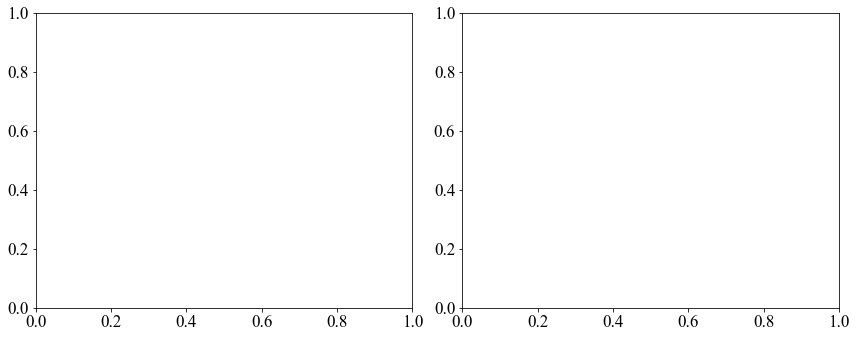

In [10]:
# Fig. 1 how much capacity is loss, how much is due to SEI and LiP?
for mm in range(0,1):
    fs=17;Num_subplot = 2;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
    axs[0].plot(cycles, Cap_RPT_NonDry_All,     '-o', label='w/o dry-out model')    # label='Diff_OutSEI = '+'%.2g' % Ratio_excess_succeed[i]+"[m2.s-1]" 
    axs[1].plot(cycles, CapLoss_LiP_NonDry_All ,'-o', label='w/o dry-out model')  
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles, Cap_RPT_Dry_All_All[i],     '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(cycles, CapLoss_LiP_Dry_All_All[i] ,'-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Charge throughput [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Capacity [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_title("Discharge capacity",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("Capacity loss to Lithium plating",   fontdict={'family':'Times New Roman','size':fs+1})
    ##plt.savefig(BasicPath + Target+"/Fig-1a Capacity loss vs Charge throughput.png", dpi=600)

    Num_subplot = 2;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
    axs[0].plot(cycles, R_Local_ECM_NonDry_All,     '-o', label='w/o dry-out model')    # label='Diff_OutSEI = '+'%.2g' % Ratio_excess_succeed[i]+"[m2.s-1]" 
    axs[1].plot(cycles, Cap_Neg_NonDry_All[0]- Cap_Neg_NonDry_All ,'-o', label='Neg')  
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[1].plot(cycles, Cap_Neg_Dry_All_All[i][0]-Cap_Neg_Dry_All_All[i]     ,'-o', )
    axs[1].plot(cycles, Cap_Pos_NonDry_All[0]-Cap_Pos_NonDry_All  ,     '-^', label='Pos')    
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[1].plot(cycles, Cap_Pos_Dry_All_All[i][0]-Cap_Pos_Dry_All_All[i]     ,'-^', )
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles, R_Local_ECM_Dry_All_All[i],     '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    for i in range(0,1):
        axs[i].set_xlabel("Charge throughput [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_ylabel("ECM resistance [Ohm]",   fontdict={'family':'Times New Roman','size':fs})
    axs[0].set_title("Local ECM resistance",   fontdict={'family':'Times New Roman','size':fs+1})
    for i in range(1,2):
        axs[i].set_xlabel("Charge throughput [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Capacity [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[1].set_title("LAM of Neg and Pos",   fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"/Fig-1b Resistance LAM vs Charge throughput.png", dpi=600)

NameError: name 'Time_RPT_CDend_NonDry_All' is not defined

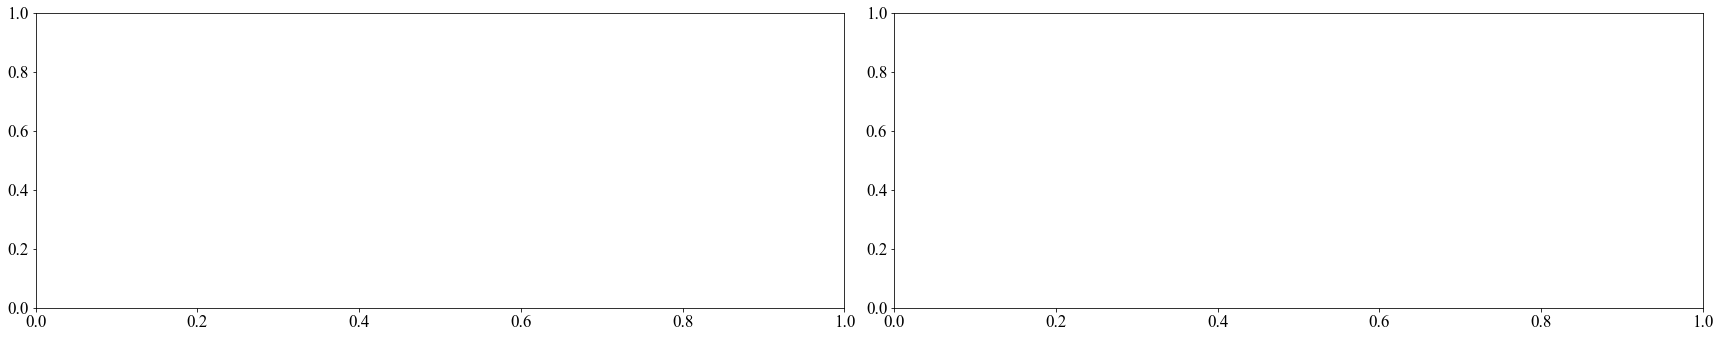

In [11]:
# Fig-2 model validation -  Vol_RPT_CDend_NonDry_All
for mm in range(0,1):
    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1; 
    # compare different Time_RPT_CDend_NonDry_All in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(Time_RPT_CDend_NonDry_All[i],     Vol_RPT_CDend_NonDry_All[i],    '-',label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(Time_RPT_CDend_Dry_All_All[k-1][i], Vol_RPT_CDend_Dry_All_All[k-1][i], '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Time [h]",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Terminal voltage [V]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        axs[i].set_ylim(2.5,4.2)

    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-2a Terminal voltage- compare different cycles.png", dpi=600)

    # compare first and last cycle in one subplot:
    Num_subplot = 2; fs=19
    fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
    axs[0].plot(Time_RPT_CDend_NonDry_All[0], Vol_RPT_CDend_NonDry_All[0], '-', label="Non Dry out" ) # first cycle
    axs[1].plot(Time_RPT_CDend_NonDry_All[-1], Vol_RPT_CDend_NonDry_All[-1], '-',label="Non Dry out" ) # last cycle
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[0].plot(Time_RPT_CDend_Dry_All_All[i][0], Vol_RPT_CDend_Dry_All_All[i][0],  '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # first cycle
        axs[1].plot(Time_RPT_CDend_Dry_All_All[i][-1], Vol_RPT_CDend_Dry_All_All[i][-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # last cycle
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Time [h]",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Terminal voltage [V]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)  
        axs[i].set_ylim(2.5,4.2)
    axs[0].set_title(f"First RPT cycle", fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title(f"Last RPT cycle", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-2b Terminal voltage - compare different excessive electrolyte.png", dpi=600) 

In [ ]:
####Fig-S1 Check total lithium in JR
for mm in range(0,1):
    Num_subplot = 4;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    axs[0].plot(cycles, Tot_Li_JR_CCend_NonDry_All,     '-o', label='w/o dry-out model')    # label='Diff_OutSEI = '+'%.2g' % Ratio_excess_succeed[i]+"[m2.s-1]" 
    axs[1].plot(cycles, Tot_Li_Elely_CCend_NonDry_All ,'-o', label='w/o dry-out model')  
    axs[2].plot(cycles, Tot_Li_Solid_CCend_NonDry_All ,'-o', label='w/o dry-out model')  
    axs[3].plot(cycles, Tot_LiLoss_Solid_CCend_NonDry_All ,'-o', label='w/o dry-out model') 
    axs[3].plot(cycles, Tot_LiLoss_Elely_CCend_NonDry_All ,'--', ) # label='w/o dry-out model'
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles, Tot_Li_JR_CCend_Dry_All_All[i],     '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(cycles, Tot_Li_Elely_CCend_Dry_All_All[i]     ,'-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(cycles, Tot_Li_Solid_CCend_Dry_All_All[i]     ,'-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[3].plot(cycles, Tot_LiLoss_Solid_CCend_Dry_All_All[i]     ,'-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[3].plot(cycles, Tot_LiLoss_Elely_CCend_Dry_All_All[i]     ,'--',  ) # label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte"
    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Li+ amount [mol]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_title("Total lithium in JR",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("Total lithium in electrolyte",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title("Total lithium in particles",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[3].set_title("Li loss from paericles (-o) & electrolyte (--)",   fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"/Fig-S1a Total lithium in JR, Elely and particles vs cycle number.png", dpi=600)

    Num_subplot =2;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
    axs[0].plot(cycles, np.sum([Tot_Li_JR_CCend_NonDry_All ,Tot_LiLoss_Solid_CCend_NonDry_All],axis=0) ,     '-o', label='w/o dry-out model')    # label='Diff_OutSEI = '+'%.2g' % Ratio_excess_succeed[i]+"[m2.s-1]" 
    axs[1].plot(cycles, np.sum([Tot_Li_Solid_CCend_NonDry_All , Tot_LiLoss_Solid_CCend_NonDry_All],axis=0)  ,'-o', label='w/o dry-out model')  
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles, np.sum([Tot_Li_JR_CCend_Dry_All_All[i] , Tot_LiLoss_Solid_CCend_Dry_All_All[i]],axis=0),     '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(cycles, np.sum([Tot_Li_Solid_CCend_Dry_All_All[i] , Tot_LiLoss_Solid_CCend_Dry_All_All[i] ],axis=0)    ,'-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Li+ amount [mol]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_title("Total Li in JR + Li loss in from particles",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("Total Li in particles + Li loss in from particles",   fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"/Fig-S1b Total Li in JR + Li loss in from particles vs cycle number.png", dpi=600)


NameError: name 'Vol_Pore_JR_NonDry_All' is not defined

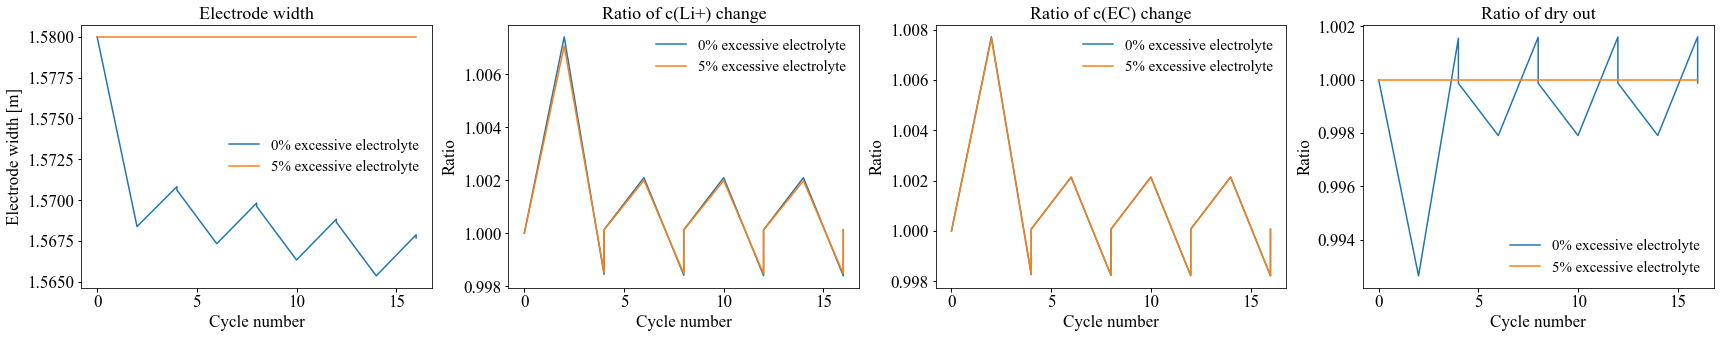

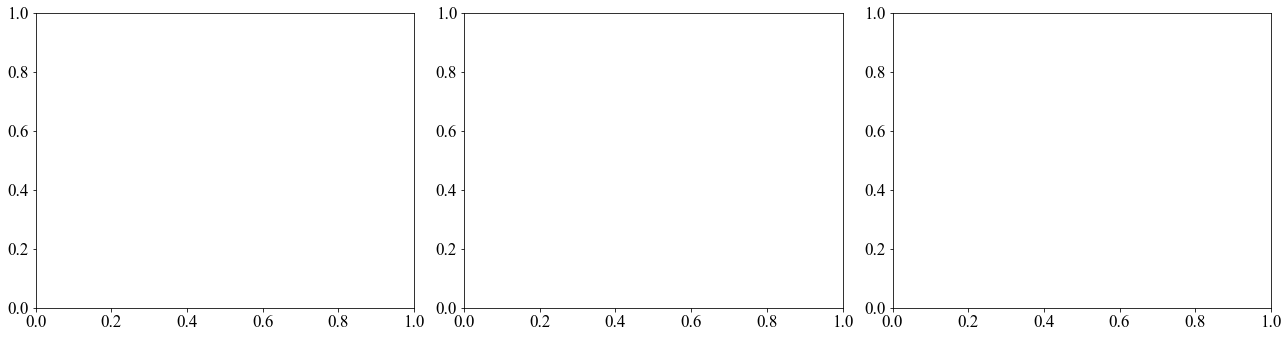

In [9]:
# Fig. 3 decsripiton of electrolyte dry-out
for mm in range(0,1):
    CeEC_All_All = [];
    for m in range(0,np.size(Ratio_excess_succeed)):
        CeEC_All =np.full(np.size(Ratio_CeEC_All_All[m]),Bulk_Sol_Con); 
        for i in range(1,np.size(Ratio_CeEC_All_All[m])):
            for k in range(0,i):
                CeEC_All[i] *= Ratio_CeEC_All_All[m][k];
        CeEC_All_All.append(CeEC_All);
    """ Vol_Elely_Tot_All_All.append(Vol_Elely_Tot_All) ;      Vol_Elely_JR_All_All.append(Vol_Elely_JR_All);          Vol_Pore_tot_All_All.append(Vol_Pore_tot_All);
    Ratio_CeEC_All_All.append(Ratio_CeEC_All);             Ratio_CeLi_All_All.append(Ratio_CeLi_All);              Ratio_Dryout_All_All.append(Ratio_Dryout_All);
    Vol_EC_consumed_All_All.append(Vol_EC_consumed_All);   Vol_Elely_need_All_All.append(Vol_Elely_need_All);      Width_all_All.append(Width_all);
    Vol_Elely_add_All_All.append(Vol_Elely_add_All);       Vol_Pore_decrease_All_All.append(Vol_Pore_decrease_All); """
    # modify:
    """ Width_all_All_md =[]; Ratio_CeLi_All_All_md=[]; Ratio_CeEC_All_All_md =[]; Ratio_Dryout_All_All_md =[];
    for m in index2:
        Width_all_All_md.append(Width_all_All[m]);
        Ratio_CeLi_All_All_md.append(Ratio_CeLi_All_All[m]);
        Ratio_CeEC_All_All_md.append(Ratio_CeEC_All_All[m]);
        Ratio_Dryout_All_All_md.append(Ratio_Dryout_All_All[m]); """
    Num_subplot = 4;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles2, Width_all_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(cycles2, Ratio_CeLi_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(cycles2, Ratio_CeEC_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[3].plot(cycles2, Ratio_Dryout_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Ratio",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_ylabel("Electrode width [m]",   fontdict={'family':'Times New Roman','size':fs})

    axs[0].set_title("Electrode width",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("Ratio of c(Li+) change",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title("Ratio of c(EC) change",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[3].set_title("Ratio of dry out",   fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"/Fig-3a Dry out extent vs cycle number.png", dpi=600)    
    # How much electrolyte is consumed? What is the EC concentration over time?
    Num_subplot = 3;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(18,4.8),tight_layout=True)
    axs[2].plot(cycles, Vol_Pore_JR_NonDry_All,     '-o', label='w/o dry-out model' )
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles2, Vol_EC_consumed_All_All[i],   '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(cycles2, CeEC_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(cycles2, Vol_Pore_tot_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    axs[0].set_ylabel("Volume [mL]",   fontdict={'family':'Times New Roman','size':fs})
    axs[1].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'Times New Roman','size':fs})
    axs[2].set_ylabel("Volume [mL]",   fontdict={'family':'Times New Roman','size':fs})


    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels] ;del labels;
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_title("EC consumed Volume (each update)",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("EC concentration",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title("Total pore in JR",   fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"/Fig-3b EC Volume and EC concentration vs cycle number.png", dpi=600)  

    Num_subplot = np.size(Ratio_excess_succeed);
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24 ,4.8),tight_layout=True)
    for i in range(0,Num_subplot):
        axs[i].plot(cycles2, Vol_Elely_Tot_All_All[i],     '-o', label="Total electrolyte in cell" )
        axs[i].plot(cycles2, Vol_Elely_JR_All_All [i],     '->', label="Total electrolyte in JR" )
        axs[i].plot(cycles2, Vol_Pore_tot_All_All [i],     '-s', label="Total pore in JR" )
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Volume [mL]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
        axs[i].set_title('%.2g' % Ratio_plot[i] + f"% excessive electrolyte",   fontdict={'family':'Times New Roman','size':fs+1})

    #plt.savefig(BasicPath + Target+"/Fig-3c Volume of electrolyte and pore vs cycle number.png", dpi=600)    


In [ ]:
print(NegSoc_E_Dis_NonDry_All)

In [ ]:
# Fig-S2 SOC at start of discharge
for mm in range(0,1):
    Num_subplot = 4; fs =17;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    axs[0].plot(cycles3, NegSoc_S_Dis_NonDry_All[0],   '-o', label='w/o dry-out model')    # label='Diff_OutSEI = '+'%.2g' % Ratio_excess_succeed[i]+"[m2.s-1]" 
    axs[1].plot(cycles3, NegSoc_E_Dis_NonDry_All[0] ,  '-o', label='w/o dry-out model')  
    axs[2].plot(cycles3, PosSoc_S_Dis_NonDry_All[0],   '-o', label='w/o dry-out model')  
    axs[3].plot(cycles3, PosSoc_E_Dis_NonDry_All[0],   '-o', label='w/o dry-out model')  
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles3, NegSoc_S_Dis_Dry_All_All[i], '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(cycles3, NegSoc_E_Dis_Dry_All_All[i] ,'-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(cycles3, PosSoc_S_Dis_Dry_All_All[i], '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[3].plot(cycles3, PosSoc_E_Dis_Dry_All_All[i], '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Electrode SOC",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_title("Neg SOC at start of discharge",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("Neg SOC at end of discharge",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title("Pos SOC at start of discharge",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[3].set_title("Pos SOC at end of discharge",   fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"/Fig-S2 Electrode SOC vs cycle number.png", dpi=600)

print(np.size(index))
print(np.size(cycles))
print(np.size(Epsilon_SEI_Neg_CCend_NonDry_All))
print( Epsilon_SEI_Neg_CCend_NonDry_All[10])

In [ ]:
# effect on current density  Fig-4 j_Neg_CCend_NonDry_All  Neg interfacial i_SEI  Negative electrode current density [A.m-2]
for mm in range(0,1):
    # compare first and last cycle in one subplot:
    Num_subplot = 2; 
    fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
    Min_plt_Dry    = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in j_Neg_CCend_Dry_All_All) 
    Max_plt_Dry    = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in j_Neg_CCend_Dry_All_All)
    Min_plt_NonDry = min(min(c_s_i)   for c_s_i in j_Neg_CCend_NonDry_All) 
    Max_plt_NonDry = max(max(c_s_i)   for c_s_i in j_Neg_CCend_NonDry_All)
    Min_plt = min(Min_plt_Dry,Min_plt_NonDry); Max_plt = max(Max_plt_Dry,Max_plt_NonDry)
    axs[0].plot(x_n/np.max(x_n), j_Neg_CCend_NonDry_All[0][:-1], '-o', label="Non Dry out" ) # first cycle
    axs[1].plot(x_n/np.max(x_n), j_Neg_CCend_NonDry_All[-1][:-1], '-o',label="Non Dry out" ) # last cycle
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[0].plot(x_n/np.max(x_n), j_Neg_CCend_Dry_All_All[i][0][:-1],  '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # first cycle
        axs[1].plot(x_n/np.max(x_n), j_Neg_CCend_Dry_All_All[i][-1][:-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # last cycle
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Neg thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Neg electrode current density [A.m-2]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        axs[i].set_ylim(Min_plt-1,Max_plt) 
    axs[0].set_title(f"First Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title(f"Last Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-4a Neg electrode current density end of charge - compare different excessive electrolyte.png", dpi=600) 
    # compare Neg interfacial i_SEI:
    Num_subplot = 2; 
    fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
    Min_plt_Dry    = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in jSEI_Neg_Int_CCend_Dry_All_All) 
    Max_plt_Dry    = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in jSEI_Neg_Int_CCend_Dry_All_All)
    Min_plt_NonDry = min(min(c_s_i)   for c_s_i in jSEI_Neg_Int_CCend_NonDry_All) 
    Max_plt_NonDry = max(max(c_s_i)   for c_s_i in jSEI_Neg_Int_CCend_NonDry_All)
    Min_plt = min(Min_plt_Dry,Min_plt_NonDry); Max_plt = max(Max_plt_Dry,Max_plt_NonDry)
    axs[0].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_NonDry_All[0], '-', label="Non Dry out" ) # first cycle
    axs[1].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_NonDry_All[-1], '-',label="Non Dry out" ) # last cycle
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[0].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_Dry_All_All[i][0],  '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # first cycle
        axs[1].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_Dry_All_All[i][-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # last cycle
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Neg thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Neg SEI inter current density [A.m-2]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        axs[i].set_ylim(Min_plt*1.1,Max_plt*0.8)
    axs[0].set_title(f"First Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title(f"Last Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-4b Neg interfacial i_SEI end of charge - compare different excessive electrolyte.png", dpi=600) 



In [ ]:
print(Epsilon_CCend_Dry_All_All[2][0])
print(Epsilon_CCend_Dry_All_All[2][-1])

In [ ]:
# Fig-5a,b First and Last ageing cycle CC end c(Li+), Porosity and Porosity times electrolyte -
#  things to do: merge the tewo figures together by assigning color
for mm in range(0,1):
    Num_subplot = 3; 
    fig, axs = plt.subplots(1,Num_subplot, figsize=(21,5),tight_layout=True)
    axs[1].plot(x/np.max(x), Epsilon_CCend_NonDry_All[0], '-', label="Non Dry out" ) 
    axs[2].plot(x/np.max(x), Epsilon_ce_CCend_NonDry_All[0], '-',label="Non Dry out" )
    axs[0].plot(x/np.max(x), c_Li_Elely_CCend_NonDry_All[0], '-',label="Non Dry out" )
    # axs[3].plot(x/np.max(x), Epsilon_ce_CCend_NonDry_All[-1]/Epsilon_CCend_NonDry_All[0], '-',label="Non Dry out" )
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[1].plot(x/np.max(x), Epsilon_CCend_Dry_All_All[i][0],  '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(x/np.max(x), Epsilon_ce_CCend_Dry_All_All[i][0], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) 
        axs[0].plot(x/np.max(x), c_Li_Elely_CCend_Dry_All_All[i][0], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        # axs[3].plot(x/np.max(x), Epsilon_ce_CCend_Dry_All_All[i][-1] / Epsilon_CCend_Dry_All_All[i][0], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    axs[1].set_ylabel("Porosity",   fontdict={'family':'Times New Roman','size':fs})
    axs[2].set_ylabel("Porosity times electrolyte",   fontdict={'family':'Times New Roman','size':fs})
    axs[0].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'Times New Roman','size':fs})
    #axs[0].set_ylim(300,4800);axs[1].set_ylim(0.05,0.48);axs[2].set_ylim(0.04,0.7);
    for i in range(0,Num_subplot):    
        axs[i].set_xlim(-0.05,1.05);
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    axs[1].set_title(f"Porosity", fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title(f"Porosity times electrolyte", fontdict={'family':'Times New Roman','size':fs+1})
    axs[0].set_title(f"Li+ concentration in electrolyte", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-5a First ageing cycle CC end c(Li+), Porosity and Porosity times electrolyte.png", dpi=600) 

    Num_subplot = 3; 
    fig, axs = plt.subplots(1,Num_subplot, figsize=(21,5),tight_layout=True)
    axs[1].plot(x/np.max(x), Epsilon_CCend_NonDry_All[-1], '-', label="Non Dry out" ) 
    axs[2].plot(x/np.max(x), Epsilon_ce_CCend_NonDry_All[-1], '-',label="Non Dry out" )
    axs[0].plot(x/np.max(x), c_Li_Elely_CCend_NonDry_All[-1], '-',label="Non Dry out" )
    # axs[3].plot(x/np.max(x), Epsilon_ce_CCend_NonDry_All[-1]/Epsilon_CCend_NonDry_All[-1], '-',label="Non Dry out" )
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[1].plot(x/np.max(x), Epsilon_CCend_Dry_All_All[i][-1],  '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(x/np.max(x), Epsilon_ce_CCend_Dry_All_All[i][-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) 
        axs[0].plot(x/np.max(x), c_Li_Elely_CCend_Dry_All_All[i][-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        # axs[3].plot(x/np.max(x), Epsilon_ce_CCend_Dry_All_All[i][-1] / Epsilon_CCend_Dry_All_All[i][-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    axs[1].set_ylabel("Porosity",   fontdict={'family':'Times New Roman','size':fs})
    axs[2].set_ylabel("Porosity times electrolyte",   fontdict={'family':'Times New Roman','size':fs})
    axs[0].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'Times New Roman','size':fs})
    #axs[0].set_ylim(10,2000);axs[1].set_ylim(0.01,0.48);axs[2].set_ylim(0.001,0.9);
    for i in range(0,Num_subplot): 
        axs[i].set_xlim(-0.05,1.05);   
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    axs[1].set_title(f"Porosity", fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title(f"Porosity times electrolyte", fontdict={'family':'Times New Roman','size':fs+1})
    axs[0].set_title(f"Li+ concentration in electrolyte", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-5b Last ageing cycle CC end c(Li+), Porosity and Porosity times electrolyte.png", dpi=600) 

In [ ]:
# Fig-6a,b  effectvie ElelyConduct_CCend_NonDry_All and Effective ElelyDiff_CCend_NonDry_All 
for mm in range(0,1):
    # compare first and last cycle in one subplot:
    Num_subplot = 2; 
    fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
    axs[0].plot(x/np.max(x), Eff_ElelyDiff_CCend_NonDry_All[0],'-', label="Non Dry out" ) # first cycle
    axs[1].plot(x/np.max(x), Eff_ElelyDiff_CCend_NonDry_All[-1], '-',label="Non Dry out" ) # last cycle
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[0].plot(x/np.max(x), Eff_ElelyDiff_CCend_Dry_All_All[i][0],   '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # first cycle
        axs[1].plot(x/np.max(x), Eff_ElelyDiff_CCend_Dry_All_All[i][-1],'-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # last cycle
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Effective electrolyte diffusivity [m2.s-1]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    axs[0].set_title(f"First Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title(f"Last Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-6d Effective Electrolyte diffusivity- compare different excessive electrolyte.png", dpi=600) 

    # compare first and last cycle in one subplot:
    Num_subplot = 2; 
    fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
    axs[0].plot(x/np.max(x), Eff_ElelyConduct_CCend_NonDry_All[0] ,'-', label="Non Dry out" ) # first cycle
    axs[1].plot(x/np.max(x), Eff_ElelyConduct_CCend_NonDry_All[-1],'-',label="Non Dry out" ) # last cycle
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[0].plot(x/np.max(x), Eff_ElelyConduct_CCend_Dry_All_All[i][0], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # first cycle
        axs[1].plot(x/np.max(x), Eff_ElelyConduct_CCend_Dry_All_All[i][-1],'-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # last cycle
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Effective electrolyte conductivity [S.m-1]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        
    axs[0].set_title(f"First Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title(f"Last Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-6b Effective Electrolyte conductivity- compare different excessive electrolyte.png", dpi=600) 

In [ ]:
# Fig-S3-a,b Li+ concentration in electrolyte;Effective Electrolyte conductivity;Effective Electrolyte diffusivity- compare different cycles
for mm in range(0,1):
    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1; 
    Min_plt = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in c_Li_Elely_CCend_Dry_All_All) 
    Max_plt = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in c_Li_Elely_CCend_Dry_All_All) 
    # compare different x/np.max(x) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x/np.max(x), c_Li_Elely_CCend_NonDry_All[i],     '-', label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x/np.max(x), c_Li_Elely_CCend_Dry_All_All[k-1][i], '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Li+ concentration in electrolyte [mol.m-3]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # # axs[i].legend(prop={'family':'Times New Roman','size':fs-5},loc='best',frameon=False)  
        axs[i].set_ylim(Min_plt-0.5e3,Max_plt+0.5e3)
    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S3a Li+ concentration in electrolyte- compare different cycles.png", dpi=600)

    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1; 
    # compare different x/np.max(x) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x/np.max(x), Eff_ElelyConduct_CCend_NonDry_All[i] ,     '-', label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x/np.max(x), Eff_ElelyConduct_CCend_Dry_All_All[k-1][i] , '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Effective electrolyte conductivity [S.m-1]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # axs[i].legend(prop={'family':'Times New Roman','size':fs-5},loc='best',frameon=False)  
    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S3b Effective Electrolyte conductivity- compare different cycles.png", dpi=600)

    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1; 
    # compare different x/np.max(x) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x/np.max(x), Eff_ElelyDiff_CCend_NonDry_All[i],  '-', label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x/np.max(x), Eff_ElelyDiff_CCend_Dry_All_All[k-1][i], '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Effective electrolyte diffusivity [m2.s-1]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S3c Effective Electrolyte diffusivity- compare different cycles.png", dpi=600)


In [ ]:
# Fig-S4   Neg electrode current density end of charge;Neg interfacial i_SEI- compare different cycles
for mm in range(0,1):
    x_n_s = x_n[:-2];
    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1; 
    Min_plt = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in j_Neg_CCend_Dry_All_All) 
    Max_plt = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in j_Neg_CCend_Dry_All_All) 
    # compare different x_n/np.max(x_n) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x_n/np.max(x_n), j_Neg_CCend_NonDry_All[i][:-1],    '-',label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x_n/np.max(x_n), j_Neg_CCend_Dry_All_All[k-1][i][:-1], '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Neg thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Neg electrode current density [A.m-2]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        #axs[i].set_ylim(Min_plt-2,Max_plt)

    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S4a Neg electrode current density end of charge - compare different cycles.png", dpi=600)


    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1;  
    Min_plt = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in jSEI_Neg_Int_CCend_Dry_All_All) 
    Max_plt = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in jSEI_Neg_Int_CCend_Dry_All_All)
    # compare different x_n/np.max(x_n) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_NonDry_All[i],    '-',label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_Dry_All_All[k-1][i], '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Neg thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Neg SEI inter current density [A.m-2]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        #axs[i].set_ylim(-1e-4,-2e-5)

    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S4b Neg interfacial i_SEI- compare different cycles.png", dpi=600)


In [ ]:
# Save data:
# variables set:
mdic = {
    "Total_Cycles": Total_Cycles,
    "Cycle_bt_RPT": Cycle_bt_RPT,
    "Real_SaveAs_Cycles": Real_SaveAs_Cycles,
    "Small_Loop": Small_Loop,
    "SaveTimes": SaveTimes,
    "RPT_Cycles": RPT_Cycles,
    "Ratio_excess":        Ratio_excess,
    "Ratio_excess_succeed":        Ratio_excess_succeed,
    "Ratio_plot":        Ratio_plot,
    "index":        index,
    "index2":        index2,
    "cycles":        cycles,
    "cycles2":        cycles2,
    "cycles3":        cycles3,
    "CeEC_All_All":   CeEC_All_All,
    "NegSoc_S_Dis_NonDry_All": NegSoc_S_Dis_NonDry_All,
    "NegSoc_E_Dis_NonDry_All": NegSoc_E_Dis_NonDry_All,
    "PosSoc_S_Dis_NonDry_All": PosSoc_S_Dis_NonDry_All,
    "PosSoc_E_Dis_NonDry_All": PosSoc_E_Dis_NonDry_All,
    "NegSoc_S_Dis_Dry_All_All": NegSoc_S_Dis_Dry_All_All,
    "NegSoc_E_Dis_Dry_All_All": NegSoc_E_Dis_Dry_All_All,
    "PosSoc_S_Dis_Dry_All_All": PosSoc_S_Dis_Dry_All_All,
    "PosSoc_E_Dis_Dry_All_All": PosSoc_E_Dis_Dry_All_All,
    "Vol_Pore_JR_NonDry_All":Vol_Pore_JR_NonDry_All,
    "Vol_Elely_Tot_All_All":        Vol_Elely_Tot_All_All,
    "Vol_Elely_JR_All_All":        Vol_Elely_JR_All_All,
    "Vol_Pore_tot_All_All":        Vol_Pore_tot_All_All,
    "Ratio_CeEC_All_All":        Ratio_CeEC_All_All,
    "Ratio_CeLi_All_All":        Ratio_CeLi_All_All,
    "Ratio_Dryout_All_All":        Ratio_Dryout_All_All,
    "Vol_EC_consumed_All_All":        Vol_EC_consumed_All_All,
    "Vol_Elely_need_All_All":        Vol_Elely_need_All_All,
    "Width_all_All":        Width_all_All,
    "Vol_Elely_add_All_All":        Vol_Elely_add_All_All,
    "Vol_Pore_decrease_All_All":        Vol_Pore_decrease_All_All,
    "Tot_Li_JR_CCend_NonDry_All":Tot_Li_JR_CCend_NonDry_All,
    "Tot_Li_Elely_CCend_NonDry_All":Tot_Li_Elely_CCend_NonDry_All,
    "Tot_Li_Solid_CCend_NonDry_All":Tot_Li_Solid_CCend_NonDry_All,
    "Tot_LiLoss_Solid_CCend_NonDry_All":Tot_LiLoss_Solid_CCend_NonDry_All,
    "Tot_LiLoss_Elely_CCend_NonDry_All":Tot_LiLoss_Elely_CCend_NonDry_All,
    "Tot_Li_JR_CCend_Dry_All_All":Tot_Li_JR_CCend_Dry_All_All,
    "Tot_Li_Elely_CCend_Dry_All_All":Tot_Li_Elely_CCend_Dry_All_All,
    "Tot_Li_Solid_CCend_Dry_All_All":Tot_Li_Solid_CCend_Dry_All_All,
    "Tot_LiLoss_Solid_CCend_Dry_All_All":Tot_LiLoss_Solid_CCend_Dry_All_All,
    "Tot_LiLoss_Elely_CCend_Dry_All_All":Tot_LiLoss_Elely_CCend_Dry_All_All,

    "Total_Cycles_NonDry": Total_Cycles_NonDry,
    "SaveTimes_NonDry": SaveTimes_NonDry,
    "index_NonDry":        index_NonDry,
    "index2_NonDry":        index2_NonDry,
    "cycles_NonDry":        cycles_NonDry,
    "cycles3_NonDry":        cycles3_NonDry,  

    "Index_update_all_all":        Index_update_all_all,
    "cs_Neg_Max":    cs_Neg_Max,

    "CeEC_0":        CeEC_0,
    "CeLi_0":        CeLi_0,
    "T_0":        T_0,
    "Cap_RPT_NonDry_All":  Cap_RPT_NonDry_All,  #  
    "Charge_ThroughPut_NonDry_All":  Charge_ThroughPut_NonDry_All,
    "CapLoss_LiP_NonDry_All": CapLoss_LiP_NonDry_All,
    "molLoss_SEI_NonDry_All":molLoss_SEI_NonDry_All,
    "Cap_Pos_NonDry_All":     Cap_Pos_NonDry_All,
    "Cap_Neg_NonDry_All":     Cap_Neg_NonDry_All,
    "R_Local_ECM_NonDry_All": R_Local_ECM_NonDry_All,
    "R_Neg_X_avg_NonDry_All": R_Neg_X_avg_NonDry_All,
    "Time_RPT_CDend_NonDry_All":        Time_RPT_CDend_NonDry_All,
    "Vol_RPT_CDend_NonDry_All":         Vol_RPT_CDend_NonDry_All,

    "Cap_RPT_Dry_All_All":  Cap_RPT_Dry_All_All,
    "Charge_ThroughPut_Dry_All_All":  Charge_ThroughPut_Dry_All_All,
    "CapLoss_LiP_Dry_All_All": CapLoss_LiP_Dry_All_All,
    "molLoss_SEI_Dry_All_All":  molLoss_SEI_Dry_All_All,
    "Cap_Neg_Dry_All_All":     Cap_Neg_Dry_All_All,
    "Cap_Pos_Dry_All_All":     Cap_Pos_Dry_All_All,
    "R_Local_ECM_Dry_All_All": R_Local_ECM_Dry_All_All,
    "R_Neg_X_avg_Dry_All_All": R_Neg_X_avg_Dry_All_All,  
    "Time_RPT_CDend_Dry_All_All":         Time_RPT_CDend_Dry_All_All,
    "Vol_RPT_CDend_Dry_All_All":          Vol_RPT_CDend_Dry_All_All,

    "x_n":        x_n,
    "x":        x,
    # CC end ageing cycle
    "Epsilon_Neg_CCend_NonDry_All":       Epsilon_Neg_CCend_NonDry_All,
    "Epsilon_SEI_Neg_CCend_NonDry_All":   Epsilon_SEI_Neg_CCend_NonDry_All,
    "Epsilon_CCend_NonDry_All":           Epsilon_CCend_NonDry_All,
    "Epsilon_ce_CCend_NonDry_All":        Epsilon_ce_CCend_NonDry_All,
    "jSEI_Neg_Int_CCend_NonDry_All":      jSEI_Neg_Int_CCend_NonDry_All,
    "j_Neg_Int_CCend_NonDry_All":         j_Neg_Int_CCend_NonDry_All,
    "j_Neg_CCend_NonDry_All":             j_Neg_CCend_NonDry_All,
    "Eta_Elely_CCend_NonDry_All":     Eta_Elely_CCend_NonDry_All,
    "c_Li_Elely_CCend_NonDry_All":        c_Li_Elely_CCend_NonDry_All,
    "Eta_Neg_rec_CCend_NonDry_All":       Eta_Neg_rec_CCend_NonDry_All,
    "c_s_Neg_Surf_CCend_NonDry_All":      c_s_Neg_Surf_CCend_NonDry_All,
    "ElelyConduct_CCend_NonDry_All":      ElelyConduct_CCend_NonDry_All,
    "ElelyDiff_CCend_NonDry_All":         ElelyDiff_CCend_NonDry_All,
    "Eff_ElelyConduct_CCend_NonDry_All":  Eff_ElelyConduct_CCend_NonDry_All,
    "Eff_ElelyDiff_CCend_NonDry_All":     Eff_ElelyDiff_CCend_NonDry_All,
    # CD end ageing cycle
    "Epsilon_Neg_CDend_NonDry_All":       Epsilon_Neg_CDend_NonDry_All,
    "Epsilon_SEI_Neg_CDend_NonDry_All":   Epsilon_SEI_Neg_CDend_NonDry_All,
    "Epsilon_CDend_NonDry_All":           Epsilon_CDend_NonDry_All,
    "Epsilon_ce_CDend_NonDry_All":        Epsilon_ce_CDend_NonDry_All,
    "jSEI_Neg_Int_CDend_NonDry_All":      jSEI_Neg_Int_CDend_NonDry_All,
    "j_Neg_Int_CDend_NonDry_All":         j_Neg_Int_CDend_NonDry_All,
    "j_Neg_CDend_NonDry_All":             j_Neg_CDend_NonDry_All,
    "Eta_Elely_CDend_NonDry_All":     Eta_Elely_CDend_NonDry_All,
    "c_Li_Elely_CDend_NonDry_All":        c_Li_Elely_CDend_NonDry_All,
    "Eta_Neg_rec_CDend_NonDry_All":       Eta_Neg_rec_CDend_NonDry_All,
    "c_s_Neg_Surf_CDend_NonDry_All":      c_s_Neg_Surf_CDend_NonDry_All,
    "ElelyConduct_CDend_NonDry_All":      ElelyConduct_CDend_NonDry_All,
    "ElelyDiff_CDend_NonDry_All":         ElelyDiff_CDend_NonDry_All,
    "Eff_ElelyConduct_CDend_NonDry_All":  Eff_ElelyConduct_CDend_NonDry_All,
    "Eff_ElelyDiff_CDend_NonDry_All":     Eff_ElelyDiff_CDend_NonDry_All,


    # CC end ageing cycle
    "Epsilon_Neg_CCend_Dry_All_All"    :  Epsilon_Neg_CCend_Dry_All_All,
    "Epsilon_SEI_Neg_CCend_Dry_All_All":  Epsilon_SEI_Neg_CCend_Dry_All_All,
    "Epsilon_CCend_Dry_All_All":          Epsilon_CCend_Dry_All_All,
    "Epsilon_ce_CCend_Dry_All_All":       Epsilon_ce_CCend_Dry_All_All,
    "jSEI_Neg_Int_CCend_Dry_All_All":     jSEI_Neg_Int_CCend_Dry_All_All,
    "j_Neg_Int_CCend_Dry_All_All":        j_Neg_Int_CCend_Dry_All_All,
    "j_Neg_CCend_Dry_All_All":            j_Neg_CCend_Dry_All_All,
    "Eta_Elely_CCend_Dry_All_All":    Eta_Elely_CCend_Dry_All_All,
    "c_Li_Elely_CCend_Dry_All_All":       c_Li_Elely_CCend_Dry_All_All,
    "Eta_Neg_rec_CCend_Dry_All_All":      Eta_Neg_rec_CCend_Dry_All_All,
    "c_s_Neg_Surf_CCend_Dry_All_All":     c_s_Neg_Surf_CCend_Dry_All_All,
    "ElelyConduct_CCend_Dry_All_All":     ElelyConduct_CCend_Dry_All_All,
    "ElelyDiff_CCend_Dry_All_All":        ElelyDiff_CCend_Dry_All_All,
    "Eff_ElelyConduct_CCend_Dry_All_All": Eff_ElelyConduct_CCend_Dry_All_All,
    "Eff_ElelyDiff_CCend_Dry_All_All":    Eff_ElelyDiff_CCend_Dry_All_All,
    # CD end ageing cycle
    "Epsilon_Neg_CDend_Dry_All_All"    :  Epsilon_Neg_CDend_Dry_All_All,
    "Epsilon_SEI_Neg_CDend_Dry_All_All":  Epsilon_SEI_Neg_CDend_Dry_All_All,
    "Epsilon_CDend_Dry_All_All":          Epsilon_CDend_Dry_All_All,
    "Epsilon_ce_CDend_Dry_All_All":       Epsilon_ce_CDend_Dry_All_All,
    "jSEI_Neg_Int_CDend_Dry_All_All":     jSEI_Neg_Int_CDend_Dry_All_All,
    "j_Neg_Int_CDend_Dry_All_All":        j_Neg_Int_CDend_Dry_All_All,
    "j_Neg_CDend_Dry_All_All":            j_Neg_CDend_Dry_All_All,
    "Eta_Elely_CDend_Dry_All_All":    Eta_Elely_CDend_Dry_All_All,
    "c_Li_Elely_CDend_Dry_All_All":       c_Li_Elely_CDend_Dry_All_All,
    "Eta_Neg_rec_CDend_Dry_All_All":      Eta_Neg_rec_CDend_Dry_All_All,
    "c_s_Neg_Surf_CDend_Dry_All_All":     c_s_Neg_Surf_CDend_Dry_All_All,
    "ElelyConduct_CDend_Dry_All_All":     ElelyConduct_CDend_Dry_All_All,
    "ElelyDiff_CDend_Dry_All_All":        ElelyDiff_CDend_Dry_All_All,
    "Eff_ElelyConduct_CDend_Dry_All_All": Eff_ElelyConduct_CDend_Dry_All_All,
    "Eff_ElelyDiff_CDend_Dry_All_All":    Eff_ElelyDiff_CDend_Dry_All_All,

}
#savemat(BasicPath + Target+'StructDara_for_Mat.mat',mdic)

In [ ]:
# Print the chosen parameter set
format_str = '{:<75} {:>20}' 
print(format_str.format('PARAMETER', 'VALUE')) 
print("-"*97) 
fo = open(BasicPath + Target + "Parameter Used.txt","a+" );
for key, value in Para_0.items(): 
     try: 
            print(format_str.format(key, value)) 
            fo.write(format_str.format(key, value) + "\n");
     except TypeError: 
            print(format_str.format(key, value.__str__()))

In [ ]:
Model_0.variables.search('Total lithium')

In [ ]:
# X-averaged negative electrode open circuit potential [V];
# X-averaged positive electrode open circuit potential [V]
# Terminal voltage [V]
